Upload the basic notebook

In [108]:
%%capture
%run foundation_notebook.ipynb

In [109]:
print("Notebook run successfully!")

Notebook run successfully!


# 5. Binary classifier - architecture

We build a simple binary classifier, which distinguish between ULDM of any type and pure noise.

In [112]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten, Input, BatchNormalization, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
np.random.seed(42)

In [113]:
import importlib
import binary_classifier_function  # Import the module first

importlib.reload(binary_classifier_function)  # Reload the module
from binary_classifier_function import BinaryClassifier

# 6. Training data generation - type C

In [114]:
# mass interval - we focused on a subset of the whole range
mmin = 1e-22 * u.eV
mmax = 1e-21 * u.eV

1. run - data

In [12]:
# snr = 35
data_s0l_35_r1_C = Nruns_noisydata_SNR_fixed(N = 6000, m_list = [mmin, mmax], snr = 35, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_35_r1_C = Nruns_noisydata_SNR_fixed(N = 6000, m_list = [mmin, mmax], snr = 35, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_35_r1_C  = Nruns_noisydata_SNR_fixed(N = 6000, m_list = [mmin, mmax], snr = 35, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_35_r1_C  = Nruns_noisydata_SNR_fixed(N = 6000, m_list = [mmin, mmax], snr = 35, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 0
data_noise_r1_C  = Nruns_noisydata_SNR_fixed(N = 4 * 6000, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

Scalar

In [16]:
combined_allsp_r1_C = np.concatenate((data_noise_r1_C, data_s0l_35_r1_C, data_s0q_35_r1_C, data_s1_35_r1_C, data_s2_35_r1_C))

scaler_allsp_C = MinMaxScaler()

combined_allsp_r1_C_normalized = scaler_allsp_C.fit_transform(combined_allsp_r1_C)

In [18]:
import pickle

# Save the scalar
with open('store/files/binary_classifier_all_spins/scaler_allsp_C.pkl', 'wb') as f:
    pickle.dump(scaler_allsp_C, f)

Data 1 - normalized

In [20]:
norm_data_noise_r1_C  = scaler_allsp_C.transform(data_noise_r1_C)
norm_data_s0l_35_r1_C = scaler_allsp_C.transform(data_s0l_35_r1_C)
norm_data_s0q_35_r1_C = scaler_allsp_C.transform(data_s0q_35_r1_C)
norm_data_s1_35_r1_C  = scaler_allsp_C.transform(data_s1_35_r1_C)
norm_data_s2_35_r1_C  = scaler_allsp_C.transform(data_s2_35_r1_C)

X_allsp_r1_C = np.concatenate((norm_data_noise_r1_C, norm_data_s0l_35_r1_C, norm_data_s0q_35_r1_C, norm_data_s1_35_r1_C, norm_data_s2_35_r1_C))

y_0_allsp_r1_C = np.zeros(4 * 6000)
y_1_allsp_r1_C = np.ones(4 * 6000)
y_allsp_r1_C = np.concatenate((y_0_allsp_r1_C, y_1_allsp_r1_C)).reshape(-1,1)

# shuffle
indices_r1_C = np.random.permutation(X_allsp_r1_C.shape[0])
X_allsp_r1_C_shuffle = X_allsp_r1_C[indices_r1_C]
y_allsp_r1_C_shuffle = y_allsp_r1_C[indices_r1_C]

# split
split_r1_C = int( 0.8 * len(X_allsp_r1_C_shuffle) )
# training data
X_r1_C_train = X_allsp_r1_C_shuffle[:split_r1_C]
y_r1_C_train = y_allsp_r1_C_shuffle[:split_r1_C]
# validation data
X_r1_C_val   = X_allsp_r1_C_shuffle[split_r1_C:]
y_r1_C_val   = y_allsp_r1_C_shuffle[split_r1_C:]

In [22]:
y_r1_C_val.shape

(9600, 1)

In [24]:
del data_noise_r1_C, data_s0l_35_r1_C, data_s0q_35_r1_C, data_s1_35_r1_C, data_s2_35_r1_C
del combined_allsp_r1_C, combined_allsp_r1_C_normalized
del norm_data_noise_r1_C, norm_data_s0l_35_r1_C, norm_data_s0q_35_r1_C, norm_data_s1_35_r1_C, norm_data_s2_35_r1_C
del X_allsp_r1_C, y_0_allsp_r1_C, y_1_allsp_r1_C, y_allsp_r1_C
del X_allsp_r1_C_shuffle, y_allsp_r1_C_shuffle

In [26]:
import pickle

# Define your dictionaries as given
Xy_direct_r1_C = { 
    'X_r1_C_train': X_r1_C_train, 
    'y_r1_C_train': y_r1_C_train, 
    'X_r1_C_val': X_r1_C_val, 
    'y_r1_C_val': y_r1_C_val 
}

# Save the dictionaries to a pickle file
with open('store/files/binary_classifier_all_spins/Xy_direct_r1_C.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r1_C': Xy_direct_r1_C,
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


Data 2

In [28]:
# snr = 35
data_s0l_35_r2_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_35_r2_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_35_r2_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_35_r2_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 32
data_s0l_32_r2_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_32_r2_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_32_r2_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_32_r2_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 0
data_noise_r2_C  = Nruns_noisydata_SNR_fixed(N = 8 * 2000, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

Data 2 - normalized

In [29]:
norm_data_noise_r2_C  = scaler_allsp_C.transform(data_noise_r2_C)

norm_data_s0l_32_r2_C = scaler_allsp_C.transform(data_s0l_32_r2_C)
norm_data_s0q_32_r2_C = scaler_allsp_C.transform(data_s0q_32_r2_C)
norm_data_s1_32_r2_C  = scaler_allsp_C.transform(data_s1_32_r2_C)
norm_data_s2_32_r2_C  = scaler_allsp_C.transform(data_s2_32_r2_C)

norm_data_s0l_35_r2_C = scaler_allsp_C.transform(data_s0l_35_r2_C)
norm_data_s0q_35_r2_C = scaler_allsp_C.transform(data_s0q_35_r2_C)
norm_data_s1_35_r2_C  = scaler_allsp_C.transform(data_s1_35_r2_C)
norm_data_s2_35_r2_C  = scaler_allsp_C.transform(data_s2_35_r2_C)

X_allsp_r2_C = np.concatenate((norm_data_noise_r2_C, norm_data_s0l_32_r2_C, norm_data_s0q_32_r2_C, norm_data_s1_32_r2_C, norm_data_s2_32_r2_C , norm_data_s0l_35_r2_C, norm_data_s0q_35_r2_C, norm_data_s1_35_r2_C, norm_data_s2_35_r2_C))

y_0_allsp_r2_C = np.zeros(8 * 2000)
y_1_allsp_r2_C = np.ones(8 * 2000)
y_allsp_r2_C = np.concatenate((y_0_allsp_r2_C, y_1_allsp_r2_C)).reshape(-1,1)

# shuffle
indices_r2_C         = np.random.permutation(X_allsp_r2_C.shape[0])
X_allsp_r2_C_shuffle = X_allsp_r2_C[indices_r2_C]
y_allsp_r2_C_shuffle = y_allsp_r2_C[indices_r2_C]

# split
split_r2_C = int( 0.8 * len(X_allsp_r2_C_shuffle) )
# training data
X_r2_C_train = X_allsp_r2_C_shuffle[:split_r2_C]
y_r2_C_train = y_allsp_r2_C_shuffle[:split_r2_C]
# validation data
X_r2_C_val   = X_allsp_r2_C_shuffle[split_r2_C:]
y_r2_C_val   = y_allsp_r2_C_shuffle[split_r2_C:]

In [30]:
del data_noise_r2_C, data_s0l_35_r2_C, data_s0q_35_r2_C, data_s1_35_r2_C, data_s2_35_r2_C
del norm_data_noise_r2_C, norm_data_s0l_35_r2_C, norm_data_s0q_35_r2_C, norm_data_s1_35_r2_C, norm_data_s2_35_r2_C
del X_allsp_r2_C, y_0_allsp_r2_C, y_1_allsp_r2_C, y_allsp_r2_C
del X_allsp_r2_C_shuffle, y_allsp_r2_C_shuffle

In [31]:
Xy_direct_r2_C = { 
    'X_r2_C_train': X_r2_C_train, 
    'y_r2_C_train': y_r2_C_train, 
    'X_r2_C_val': X_r2_C_val, 
    'y_r2_C_val': y_r2_C_val 
}

with open('store/files/binary_classifier_all_spins/Xy_direct_r2_C.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r2_C': Xy_direct_r2_C,
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


Data 3

In [32]:
# snr = 35
data_s0l_35_r3_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_35_r3_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_35_r3_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_35_r3_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 32
data_s0l_32_r3_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_32_r3_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_32_r3_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_32_r3_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 29
data_s0l_29_r3_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_29_r3_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_29_r3_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_29_r3_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 0
data_noise_r3_C  = Nruns_noisydata_SNR_fixed(N = 12 * 2000, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

Data 3 - normalized

In [37]:
norm_data_noise_r3_C  = scaler_allsp_C.transform(data_noise_r3_C)

norm_data_s0l_29_r3_C = scaler_allsp_C.transform(data_s0l_29_r3_C)
norm_data_s0q_29_r3_C = scaler_allsp_C.transform(data_s0q_29_r3_C)
norm_data_s1_29_r3_C  = scaler_allsp_C.transform(data_s1_29_r3_C)
norm_data_s2_29_r3_C  = scaler_allsp_C.transform(data_s2_29_r3_C)

norm_data_s0l_32_r3_C = scaler_allsp_C.transform(data_s0l_32_r3_C)
norm_data_s0q_32_r3_C = scaler_allsp_C.transform(data_s0q_32_r3_C)
norm_data_s1_32_r3_C  = scaler_allsp_C.transform(data_s1_32_r3_C)
norm_data_s2_32_r3_C  = scaler_allsp_C.transform(data_s2_32_r3_C)

norm_data_s0l_35_r3_C = scaler_allsp_C.transform(data_s0l_35_r3_C)
norm_data_s0q_35_r3_C = scaler_allsp_C.transform(data_s0q_35_r3_C)
norm_data_s1_35_r3_C  = scaler_allsp_C.transform(data_s1_35_r3_C)
norm_data_s2_35_r3_C  = scaler_allsp_C.transform(data_s2_35_r3_C)

X_allsp_r3_C = np.concatenate((norm_data_noise_r3_C, 
                               norm_data_s0l_29_r3_C, norm_data_s0q_29_r3_C, norm_data_s1_29_r3_C, norm_data_s2_29_r3_C, 
                               norm_data_s0l_32_r3_C, norm_data_s0q_32_r3_C, norm_data_s1_32_r3_C, norm_data_s2_32_r3_C , 
                               norm_data_s0l_35_r3_C, norm_data_s0q_35_r3_C, norm_data_s1_35_r3_C, norm_data_s2_35_r3_C))

y_0_allsp_r3_C = np.zeros(12 * 2000)
y_1_allsp_r3_C = np.ones(12 * 2000)
y_allsp_r3_C = np.concatenate((y_0_allsp_r3_C, y_1_allsp_r3_C)).reshape(-1,1)

# shuffle
indices_r3_C         = np.random.permutation(X_allsp_r3_C.shape[0])
X_allsp_r3_C_shuffle = X_allsp_r3_C[indices_r3_C]
y_allsp_r3_C_shuffle = y_allsp_r3_C[indices_r3_C]

# split
split_r3_C = int( 0.8 * len(X_allsp_r3_C_shuffle) )
# training data
X_r3_C_train = X_allsp_r3_C_shuffle[:split_r3_C]
y_r3_C_train = y_allsp_r3_C_shuffle[:split_r3_C]
# validation data
X_r3_C_val   = X_allsp_r3_C_shuffle[split_r3_C:]
y_r3_C_val   = y_allsp_r3_C_shuffle[split_r3_C:]

In [38]:
del data_noise_r3_C, data_s0l_35_r3_C, data_s0q_35_r3_C, data_s1_35_r3_C, data_s2_35_r3_C
del norm_data_noise_r3_C, norm_data_s0l_35_r3_C, norm_data_s0q_35_r3_C, norm_data_s1_35_r3_C, norm_data_s2_35_r3_C
del X_allsp_r3_C, y_0_allsp_r3_C, y_1_allsp_r3_C, y_allsp_r3_C
del X_allsp_r3_C_shuffle, y_allsp_r3_C_shuffle

In [39]:
Xy_direct_r3_C = { 
    'X_r3_C_train': X_r3_C_train, 
    'y_r3_C_train': y_r3_C_train, 
    'X_r3_C_val': X_r3_C_val, 
    'y_r3_C_val': y_r3_C_val 
}

with open('store/files/binary_classifier_all_spins/Xy_direct_r3_C.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r3_C': Xy_direct_r3_C,
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


Data 4

In [40]:
# snr = 35
data_s0l_35_r4_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_35_r4_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_35_r4_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_35_r4_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 32
data_s0l_32_r4_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_32_r4_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_32_r4_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_32_r4_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 29
data_s0l_29_r4_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_29_r4_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_29_r4_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_29_r4_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 26
data_s0l_26_r4_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_26_r4_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_26_r4_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_26_r4_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 0
data_noise_r4_C  = Nruns_noisydata_SNR_fixed(N = 16 * 2000, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

Data 4 - normalized

In [41]:
norm_data_s0l_35_r4_C = scaler_allsp_C.transform(data_s0l_35_r4_C)
norm_data_s0q_35_r4_C = scaler_allsp_C.transform(data_s0q_35_r4_C)
norm_data_s1_35_r4_C  = scaler_allsp_C.transform(data_s1_35_r4_C)
norm_data_s2_35_r4_C  = scaler_allsp_C.transform(data_s2_35_r4_C)

norm_data_s0l_32_r4_C = scaler_allsp_C.transform(data_s0l_32_r4_C)
norm_data_s0q_32_r4_C = scaler_allsp_C.transform(data_s0q_32_r4_C)
norm_data_s1_32_r4_C  = scaler_allsp_C.transform(data_s1_32_r4_C)
norm_data_s2_32_r4_C  = scaler_allsp_C.transform(data_s2_32_r4_C)

norm_data_s0l_29_r4_C = scaler_allsp_C.transform(data_s0l_29_r4_C)
norm_data_s0q_29_r4_C = scaler_allsp_C.transform(data_s0q_29_r4_C)
norm_data_s1_29_r4_C  = scaler_allsp_C.transform(data_s1_29_r4_C)
norm_data_s2_29_r4_C  = scaler_allsp_C.transform(data_s2_29_r4_C)

norm_data_s0l_26_r4_C = scaler_allsp_C.transform(data_s0l_26_r4_C)
norm_data_s0q_26_r4_C = scaler_allsp_C.transform(data_s0q_26_r4_C)
norm_data_s1_26_r4_C  = scaler_allsp_C.transform(data_s1_26_r4_C)
norm_data_s2_26_r4_C  = scaler_allsp_C.transform(data_s2_26_r4_C)

norm_data_noise_r4_C  = scaler_allsp_C.transform(data_noise_r4_C)

X_allsp_r4_C = np.concatenate((norm_data_noise_r4_C, norm_data_s0l_26_r4_C, norm_data_s0q_26_r4_C, norm_data_s1_26_r4_C, norm_data_s2_26_r4_C, norm_data_s0l_29_r4_C, norm_data_s0q_29_r4_C, norm_data_s1_29_r4_C, norm_data_s2_29_r4_C, norm_data_s0l_32_r4_C, norm_data_s0q_32_r4_C, norm_data_s1_32_r4_C, norm_data_s2_32_r4_C, norm_data_s0l_35_r4_C, norm_data_s0q_35_r4_C, norm_data_s1_35_r4_C, norm_data_s2_35_r4_C))

y_0_allsp_r4_C  = np.zeros(16 * 2000)
y_1_allsp_r4_C  = np.ones(16 * 2000)
y_allsp_r4_C    = np.concatenate((y_0_allsp_r4_C, y_1_allsp_r4_C)).reshape(-1,1)

# shuffle
indices_r4_C         = np.random.permutation(X_allsp_r4_C.shape[0])
X_allsp_r4_C_shuffle = X_allsp_r4_C[indices_r4_C]
y_allsp_r4_C_shuffle = y_allsp_r4_C[indices_r4_C]

# split
split_r4_C = int( 0.8 * len(X_allsp_r4_C_shuffle) )
# training data
X_r4_C_train = X_allsp_r4_C_shuffle[:split_r4_C]
y_r4_C_train = y_allsp_r4_C_shuffle[:split_r4_C]
# validation data
X_r4_C_val   = X_allsp_r4_C_shuffle[split_r4_C:]
y_r4_C_val   = y_allsp_r4_C_shuffle[split_r4_C:]

In [42]:
del data_noise_r4_C, data_s0l_35_r4_C, data_s0q_35_r4_C, data_s1_35_r4_C, data_s2_35_r4_C
del norm_data_noise_r4_C, norm_data_s0l_35_r4_C, norm_data_s0q_35_r4_C, norm_data_s1_35_r4_C, norm_data_s2_35_r4_C
del X_allsp_r4_C, y_0_allsp_r4_C, y_1_allsp_r4_C, y_allsp_r4_C
del X_allsp_r4_C_shuffle, y_allsp_r4_C_shuffle

In [43]:
Xy_direct_r4_C = { 
    'X_r4_C_train': X_r4_C_train, 
    'y_r4_C_train': y_r4_C_train, 
    'X_r4_C_val': X_r4_C_val, 
    'y_r4_C_val': y_r4_C_val 
}

with open('store/files/binary_classifier_all_spins/Xy_direct_r4_C.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r4_C': Xy_direct_r4_C,
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


Data 5

In [45]:
# snr = 35
data_s0l_35_r5_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_35_r5_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_35_r5_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_35_r5_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 32
data_s0l_32_r5_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_32_r5_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_32_r5_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_32_r5_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 29
data_s0l_29_r5_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_29_r5_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_29_r5_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_29_r5_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 26
data_s0l_26_r5_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_26_r5_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_26_r5_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_26_r5_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 23
data_s0l_23_r5_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_23_r5_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_23_r5_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_23_r5_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 0
data_noise_r5_C  = Nruns_noisydata_SNR_fixed(N = 20 * 2000, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

Data 5 - normalized

In [49]:
norm_data_s0l_35_r5_C = scaler_allsp_C.transform(data_s0l_35_r5_C)
norm_data_s0q_35_r5_C = scaler_allsp_C.transform(data_s0q_35_r5_C)
norm_data_s1_35_r5_C  = scaler_allsp_C.transform(data_s1_35_r5_C)
norm_data_s2_35_r5_C  = scaler_allsp_C.transform(data_s2_35_r5_C)

norm_data_s0l_32_r5_C = scaler_allsp_C.transform(data_s0l_32_r5_C)
norm_data_s0q_32_r5_C = scaler_allsp_C.transform(data_s0q_32_r5_C)
norm_data_s1_32_r5_C  = scaler_allsp_C.transform(data_s1_32_r5_C)
norm_data_s2_32_r5_C  = scaler_allsp_C.transform(data_s2_32_r5_C)

norm_data_s0l_29_r5_C = scaler_allsp_C.transform(data_s0l_29_r5_C)
norm_data_s0q_29_r5_C = scaler_allsp_C.transform(data_s0q_29_r5_C)
norm_data_s1_29_r5_C  = scaler_allsp_C.transform(data_s1_29_r5_C)
norm_data_s2_29_r5_C  = scaler_allsp_C.transform(data_s2_29_r5_C)

norm_data_s0l_26_r5_C = scaler_allsp_C.transform(data_s0l_26_r5_C)
norm_data_s0q_26_r5_C = scaler_allsp_C.transform(data_s0q_26_r5_C)
norm_data_s1_26_r5_C  = scaler_allsp_C.transform(data_s1_26_r5_C)
norm_data_s2_26_r5_C  = scaler_allsp_C.transform(data_s2_26_r5_C)

norm_data_s0l_23_r5_C = scaler_allsp_C.transform(data_s0l_26_r5_C)
norm_data_s0q_23_r5_C = scaler_allsp_C.transform(data_s0q_26_r5_C)
norm_data_s1_23_r5_C  = scaler_allsp_C.transform(data_s1_26_r5_C)
norm_data_s2_23_r5_C  = scaler_allsp_C.transform(data_s2_26_r5_C)

norm_data_noise_r5_C  = scaler_allsp_C.transform(data_noise_r5_C)

X_allsp_r5_C = np.concatenate((norm_data_noise_r5_C, norm_data_s0l_23_r5_C, norm_data_s0q_23_r5_C, norm_data_s1_23_r5_C, norm_data_s2_23_r5_C, norm_data_s0l_26_r5_C, norm_data_s0q_26_r5_C, norm_data_s1_26_r5_C, norm_data_s2_26_r5_C, norm_data_s0l_29_r5_C, norm_data_s0q_29_r5_C, norm_data_s1_29_r5_C, norm_data_s2_29_r5_C, norm_data_s0l_32_r5_C, norm_data_s0q_32_r5_C, norm_data_s1_32_r5_C, norm_data_s2_32_r5_C, norm_data_s0l_35_r5_C, norm_data_s0q_35_r5_C, norm_data_s1_35_r5_C, norm_data_s2_35_r5_C))

y_0_allsp_r5_C  = np.zeros(20 * 2000)
y_1_allsp_r5_C  = np.ones(20 * 2000)
y_allsp_r5_C    = np.concatenate((y_0_allsp_r5_C, y_1_allsp_r5_C)).reshape(-1,1)

# shuffle
indices_r5_C         = np.random.permutation(X_allsp_r5_C.shape[0])
X_allsp_r5_C_shuffle = X_allsp_r5_C[indices_r5_C]
y_allsp_r5_C_shuffle = y_allsp_r5_C[indices_r5_C]

# split
split_r5_C = int( 0.8 * len(X_allsp_r5_C_shuffle) )
# training data
X_r5_C_train = X_allsp_r5_C_shuffle[:split_r5_C]
y_r5_C_train = y_allsp_r5_C_shuffle[:split_r5_C]
# validation data
X_r5_C_val   = X_allsp_r5_C_shuffle[split_r5_C:]
y_r5_C_val   = y_allsp_r5_C_shuffle[split_r5_C:]

In [50]:
del data_noise_r5_C,
del data_s0l_35_r5_C, data_s0q_35_r5_C, data_s1_35_r5_C, data_s2_35_r5_C,
del data_s0l_32_r5_C, data_s0q_32_r5_C, data_s1_32_r5_C, data_s2_32_r5_C,
del data_s0l_29_r5_C, data_s0q_29_r5_C, data_s1_29_r5_C, data_s2_29_r5_C,
del data_s0l_26_r5_C, data_s0q_26_r5_C, data_s1_26_r5_C, data_s2_26_r5_C,
del data_s0l_23_r5_C, data_s0q_23_r5_C, data_s1_23_r5_C, data_s2_23_r5_C

del norm_data_noise_r5_C,
del norm_data_s0l_35_r5_C, norm_data_s0q_35_r5_C, norm_data_s1_35_r5_C, norm_data_s2_35_r5_C,
del norm_data_s0l_32_r5_C, norm_data_s0q_32_r5_C, norm_data_s1_32_r5_C, norm_data_s2_32_r5_C,
del norm_data_s0l_29_r5_C, norm_data_s0q_29_r5_C, norm_data_s1_29_r5_C, norm_data_s2_29_r5_C,
del norm_data_s0l_26_r5_C, norm_data_s0q_26_r5_C, norm_data_s1_26_r5_C, norm_data_s2_26_r5_C,
del norm_data_s0l_23_r5_C, norm_data_s0q_23_r5_C, norm_data_s1_23_r5_C, norm_data_s2_23_r5_C

del X_allsp_r5_C, y_0_allsp_r5_C, y_1_allsp_r5_C, y_allsp_r5_C
del X_allsp_r5_C_shuffle, y_allsp_r5_C_shuffle

In [51]:
Xy_direct_r5_C = { 
    'X_r5_C_train': X_r5_C_train, 
    'y_r5_C_train': y_r5_C_train, 
    'X_r5_C_val': X_r5_C_val, 
    'y_r5_C_val': y_r5_C_val 
}

with open('store/files/binary_classifier_all_spins/Xy_direct_r5_C.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r5_C': Xy_direct_r5_C,
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


Data 6

In [52]:
# snr = 35
data_s0l_35_r6_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_35_r6_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_35_r6_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_35_r6_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 32
data_s0l_32_r6_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_32_r6_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_32_r6_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_32_r6_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 29
data_s0l_29_r6_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_29_r6_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_29_r6_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_29_r6_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 26
data_s0l_26_r6_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_26_r6_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_26_r6_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_26_r6_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 23
data_s0l_23_r6_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_23_r6_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_23_r6_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_23_r6_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 20
data_s0l_20_r6_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 20, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_20_r6_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 20, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_20_r6_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 20, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_20_r6_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 20, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 0
data_noise_r6_C  = Nruns_noisydata_SNR_fixed(N = 24 * 2000, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

Data 6 - normalized

In [53]:
norm_data_s0l_35_r6_C = scaler_allsp_C.transform(data_s0l_35_r6_C)
norm_data_s0q_35_r6_C = scaler_allsp_C.transform(data_s0q_35_r6_C)
norm_data_s1_35_r6_C  = scaler_allsp_C.transform(data_s1_35_r6_C)
norm_data_s2_35_r6_C  = scaler_allsp_C.transform(data_s2_35_r6_C)

norm_data_s0l_32_r6_C = scaler_allsp_C.transform(data_s0l_32_r6_C)
norm_data_s0q_32_r6_C = scaler_allsp_C.transform(data_s0q_32_r6_C)
norm_data_s1_32_r6_C  = scaler_allsp_C.transform(data_s1_32_r6_C)
norm_data_s2_32_r6_C  = scaler_allsp_C.transform(data_s2_32_r6_C)

norm_data_s0l_29_r6_C = scaler_allsp_C.transform(data_s0l_29_r6_C)
norm_data_s0q_29_r6_C = scaler_allsp_C.transform(data_s0q_29_r6_C)
norm_data_s1_29_r6_C  = scaler_allsp_C.transform(data_s1_29_r6_C)
norm_data_s2_29_r6_C  = scaler_allsp_C.transform(data_s2_29_r6_C)

norm_data_s0l_26_r6_C = scaler_allsp_C.transform(data_s0l_26_r6_C)
norm_data_s0q_26_r6_C = scaler_allsp_C.transform(data_s0q_26_r6_C)
norm_data_s1_26_r6_C  = scaler_allsp_C.transform(data_s1_26_r6_C)
norm_data_s2_26_r6_C  = scaler_allsp_C.transform(data_s2_26_r6_C)

norm_data_s0l_23_r6_C = scaler_allsp_C.transform(data_s0l_23_r6_C)
norm_data_s0q_23_r6_C = scaler_allsp_C.transform(data_s0q_23_r6_C)
norm_data_s1_23_r6_C  = scaler_allsp_C.transform(data_s1_23_r6_C)
norm_data_s2_23_r6_C  = scaler_allsp_C.transform(data_s2_23_r6_C)

norm_data_s0l_20_r6_C = scaler_allsp_C.transform(data_s0l_20_r6_C)
norm_data_s0q_20_r6_C = scaler_allsp_C.transform(data_s0q_20_r6_C)
norm_data_s1_20_r6_C  = scaler_allsp_C.transform(data_s1_20_r6_C)
norm_data_s2_20_r6_C  = scaler_allsp_C.transform(data_s2_20_r6_C)

norm_data_noise_r6_C  = scaler_allsp_C.transform(data_noise_r6_C)

X_allsp_r6_C = np.concatenate((norm_data_noise_r6_C, 
                               norm_data_s0l_20_r6_C, norm_data_s0q_20_r6_C, norm_data_s1_20_r6_C, norm_data_s2_20_r6_C,
                               norm_data_s0l_23_r6_C, norm_data_s0q_23_r6_C, norm_data_s1_23_r6_C, norm_data_s2_23_r6_C, 
                               norm_data_s0l_26_r6_C, norm_data_s0q_26_r6_C, norm_data_s1_26_r6_C, norm_data_s2_26_r6_C, 
                               norm_data_s0l_29_r6_C, norm_data_s0q_29_r6_C, norm_data_s1_29_r6_C, norm_data_s2_29_r6_C, 
                               norm_data_s0l_32_r6_C, norm_data_s0q_32_r6_C, norm_data_s1_32_r6_C, norm_data_s2_32_r6_C, 
                               norm_data_s0l_35_r6_C, norm_data_s0q_35_r6_C, norm_data_s1_35_r6_C, norm_data_s2_35_r6_C))

y_0_allsp_r6_C  = np.zeros(24 * 2000)
y_1_allsp_r6_C  = np.ones(24 * 2000)
y_allsp_r6_C    = np.concatenate((y_0_allsp_r6_C, y_1_allsp_r6_C)).reshape(-1,1)

# shuffle
indices_r6_C         = np.random.permutation(X_allsp_r6_C.shape[0])
X_allsp_r6_C_shuffle = X_allsp_r6_C[indices_r6_C]
y_allsp_r6_C_shuffle = y_allsp_r6_C[indices_r6_C]

# split
split_r6_C = int( 0.8 * len(X_allsp_r6_C_shuffle) )
# training data
X_r6_C_train = X_allsp_r6_C_shuffle[:split_r6_C]
y_r6_C_train = y_allsp_r6_C_shuffle[:split_r6_C]
# validation data
X_r6_C_val   = X_allsp_r6_C_shuffle[split_r6_C:]
y_r6_C_val   = y_allsp_r6_C_shuffle[split_r6_C:]

In [54]:
del data_noise_r6_C,
del data_s0l_35_r6_C, data_s0q_35_r6_C, data_s1_35_r6_C, data_s2_35_r6_C,
del data_s0l_32_r6_C, data_s0q_32_r6_C, data_s1_32_r6_C, data_s2_32_r6_C,
del data_s0l_29_r6_C, data_s0q_29_r6_C, data_s1_29_r6_C, data_s2_29_r6_C,
del data_s0l_26_r6_C, data_s0q_26_r6_C, data_s1_26_r6_C, data_s2_26_r6_C,
del data_s0l_23_r6_C, data_s0q_23_r6_C, data_s1_23_r6_C, data_s2_23_r6_C,
del data_s0l_20_r6_C, data_s0q_20_r6_C, data_s1_20_r6_C, data_s2_20_r6_C,

del norm_data_noise_r6_C,
del norm_data_s0l_35_r6_C, norm_data_s0q_35_r6_C, norm_data_s1_35_r6_C, norm_data_s2_35_r6_C,
del norm_data_s0l_32_r6_C, norm_data_s0q_32_r6_C, norm_data_s1_32_r6_C, norm_data_s2_32_r6_C,
del norm_data_s0l_29_r6_C, norm_data_s0q_29_r6_C, norm_data_s1_29_r6_C, norm_data_s2_29_r6_C,
del norm_data_s0l_26_r6_C, norm_data_s0q_26_r6_C, norm_data_s1_26_r6_C, norm_data_s2_26_r6_C,
del norm_data_s0l_23_r6_C, norm_data_s0q_23_r6_C, norm_data_s1_23_r6_C, norm_data_s2_23_r6_C,
del norm_data_s0l_20_r6_C, norm_data_s0q_20_r6_C, norm_data_s1_20_r6_C, norm_data_s2_20_r6_C,

del X_allsp_r6_C, y_0_allsp_r6_C, y_1_allsp_r6_C, y_allsp_r6_C
del X_allsp_r6_C_shuffle, y_allsp_r6_C_shuffle

In [64]:
Xy_direct_r6_C = { 
    'X_r6_C_train': X_r6_C_train, 
    'y_r6_C_train': y_r6_C_train, 
    'X_r6_C_val': X_r6_C_val, 
    'y_r6_C_val': y_r6_C_val 
}

with open('store/files/binary_classifier_all_spins/Xy_direct_r6_C.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r6_C': Xy_direct_r6_C,
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


Data 7

In [66]:
# snr = 35
data_s0l_35_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_35_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_35_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_35_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 35, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 32
data_s0l_32_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_32_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_32_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_32_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 32, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 29
data_s0l_29_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_29_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_29_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_29_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 29, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 26
data_s0l_26_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_26_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_26_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_26_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 23
data_s0l_23_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_23_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_23_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_23_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 26, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 20
data_s0l_20_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 20, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_20_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 20, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_20_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 20, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_20_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 20, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 17
data_s0l_17_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 17, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_17_r7_C = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 17, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_17_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 17, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_17_r7_C  = Nruns_noisydata_SNR_fixed(N = 2000, m_list = [mmin, mmax], snr = 17, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 0
data_noise_r7_C  = Nruns_noisydata_SNR_fixed(N = 28 * 2000, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

Data 7 - normalized

In [68]:
# Normalizing data for r7
norm_data_s0l_35_r7_C = scaler_allsp_C.transform(data_s0l_35_r7_C)
norm_data_s0q_35_r7_C = scaler_allsp_C.transform(data_s0q_35_r7_C)
norm_data_s1_35_r7_C  = scaler_allsp_C.transform(data_s1_35_r7_C)
norm_data_s2_35_r7_C  = scaler_allsp_C.transform(data_s2_35_r7_C)

norm_data_s0l_32_r7_C = scaler_allsp_C.transform(data_s0l_32_r7_C)
norm_data_s0q_32_r7_C = scaler_allsp_C.transform(data_s0q_32_r7_C)
norm_data_s1_32_r7_C  = scaler_allsp_C.transform(data_s1_32_r7_C)
norm_data_s2_32_r7_C  = scaler_allsp_C.transform(data_s2_32_r7_C)

norm_data_s0l_29_r7_C = scaler_allsp_C.transform(data_s0l_29_r7_C)
norm_data_s0q_29_r7_C = scaler_allsp_C.transform(data_s0q_29_r7_C)
norm_data_s1_29_r7_C  = scaler_allsp_C.transform(data_s1_29_r7_C)
norm_data_s2_29_r7_C  = scaler_allsp_C.transform(data_s2_29_r7_C)

norm_data_s0l_26_r7_C = scaler_allsp_C.transform(data_s0l_26_r7_C)
norm_data_s0q_26_r7_C = scaler_allsp_C.transform(data_s0q_26_r7_C)
norm_data_s1_26_r7_C  = scaler_allsp_C.transform(data_s1_26_r7_C)
norm_data_s2_26_r7_C  = scaler_allsp_C.transform(data_s2_26_r7_C)

norm_data_s0l_23_r7_C = scaler_allsp_C.transform(data_s0l_23_r7_C)
norm_data_s0q_23_r7_C = scaler_allsp_C.transform(data_s0q_23_r7_C)
norm_data_s1_23_r7_C  = scaler_allsp_C.transform(data_s1_23_r7_C)
norm_data_s2_23_r7_C  = scaler_allsp_C.transform(data_s2_23_r7_C)

norm_data_s0l_20_r7_C = scaler_allsp_C.transform(data_s0l_20_r7_C)
norm_data_s0q_20_r7_C = scaler_allsp_C.transform(data_s0q_20_r7_C)
norm_data_s1_20_r7_C  = scaler_allsp_C.transform(data_s1_20_r7_C)
norm_data_s2_20_r7_C  = scaler_allsp_C.transform(data_s2_20_r7_C)

norm_data_s0l_17_r7_C = scaler_allsp_C.transform(data_s0l_17_r7_C)
norm_data_s0q_17_r7_C = scaler_allsp_C.transform(data_s0q_17_r7_C)
norm_data_s1_17_r7_C  = scaler_allsp_C.transform(data_s1_17_r7_C)
norm_data_s2_17_r7_C  = scaler_allsp_C.transform(data_s2_17_r7_C)

norm_data_noise_r7_C  = scaler_allsp_C.transform(data_noise_r7_C)

# Concatenate all data for r7
X_allsp_r7_C = np.concatenate((norm_data_noise_r7_C,
                               norm_data_s0l_17_r7_C, norm_data_s0q_17_r7_C, norm_data_s1_17_r7_C, norm_data_s2_17_r7_C,
                               norm_data_s0l_20_r7_C, norm_data_s0q_20_r7_C, norm_data_s1_20_r7_C, norm_data_s2_20_r7_C,
                               norm_data_s0l_23_r7_C, norm_data_s0q_23_r7_C, norm_data_s1_23_r7_C, norm_data_s2_23_r7_C, 
                               norm_data_s0l_26_r7_C, norm_data_s0q_26_r7_C, norm_data_s1_26_r7_C, norm_data_s2_26_r7_C, 
                               norm_data_s0l_29_r7_C, norm_data_s0q_29_r7_C, norm_data_s1_29_r7_C, norm_data_s2_29_r7_C, 
                               norm_data_s0l_32_r7_C, norm_data_s0q_32_r7_C, norm_data_s1_32_r7_C, norm_data_s2_32_r7_C, 
                               norm_data_s0l_35_r7_C, norm_data_s0q_35_r7_C, norm_data_s1_35_r7_C, norm_data_s2_35_r7_C))

y_0_allsp_r7_C  = np.zeros(28 * 2000)
y_1_allsp_r7_C  = np.ones(28 * 2000)
y_allsp_r7_C    = np.concatenate((y_0_allsp_r7_C, y_1_allsp_r7_C)).reshape(-1,1)

# shuffle
indices_r7_C         = np.random.permutation(X_allsp_r7_C.shape[0])
X_allsp_r7_C_shuffle = X_allsp_r7_C[indices_r7_C]
y_allsp_r7_C_shuffle = y_allsp_r7_C[indices_r7_C]

# split
split_r7_C = int( 0.8 * len(X_allsp_r7_C_shuffle) )
# training data
X_r7_C_train = X_allsp_r7_C_shuffle[:split_r7_C]
y_r7_C_train = y_allsp_r7_C_shuffle[:split_r7_C]
# validation data
X_r7_C_val   = X_allsp_r7_C_shuffle[split_r7_C:]
y_r7_C_val   = y_allsp_r7_C_shuffle[split_r7_C:]

In [70]:
del data_noise_r7_C,
del data_s0l_35_r7_C, data_s0q_35_r7_C, data_s1_35_r7_C, data_s2_35_r7_C,
del data_s0l_32_r7_C, data_s0q_32_r7_C, data_s1_32_r7_C, data_s2_32_r7_C,
del data_s0l_29_r7_C, data_s0q_29_r7_C, data_s1_29_r7_C, data_s2_29_r7_C,
del data_s0l_26_r7_C, data_s0q_26_r7_C, data_s1_26_r7_C, data_s2_26_r7_C,
del data_s0l_23_r7_C, data_s0q_23_r7_C, data_s1_23_r7_C, data_s2_23_r7_C,
del data_s0l_20_r7_C, data_s0q_20_r7_C, data_s1_20_r7_C, data_s2_20_r7_C,
del data_s0l_17_r7_C, data_s0q_17_r7_C, data_s1_17_r7_C, data_s2_17_r7_C,

del norm_data_noise_r7_C,
del norm_data_s0l_35_r7_C, norm_data_s0q_35_r7_C, norm_data_s1_35_r7_C, norm_data_s2_35_r7_C,
del norm_data_s0l_32_r7_C, norm_data_s0q_32_r7_C, norm_data_s1_32_r7_C, norm_data_s2_32_r7_C,
del norm_data_s0l_29_r7_C, norm_data_s0q_29_r7_C, norm_data_s1_29_r7_C, norm_data_s2_29_r7_C,
del norm_data_s0l_26_r7_C, norm_data_s0q_26_r7_C, norm_data_s1_26_r7_C, norm_data_s2_26_r7_C,
del norm_data_s0l_23_r7_C, norm_data_s0q_23_r7_C, norm_data_s1_23_r7_C, norm_data_s2_23_r7_C,
del norm_data_s0l_20_r7_C, norm_data_s0q_20_r7_C, norm_data_s1_20_r7_C, norm_data_s2_20_r7_C,
del norm_data_s0l_17_r7_C, norm_data_s0q_17_r7_C, norm_data_s1_17_r7_C, norm_data_s2_17_r7_C,

del X_allsp_r7_C, y_0_allsp_r7_C, y_1_allsp_r7_C, y_allsp_r7_C
del X_allsp_r7_C_shuffle, y_allsp_r7_C_shuffle

In [72]:
Xy_direct_r7_C = { 
    'X_r7_C_train': X_r7_C_train, 
    'y_r7_C_train': y_r7_C_train, 
    'X_r7_C_val': X_r7_C_val, 
    'y_r7_C_val': y_r7_C_val 
}

with open('store/files/binary_classifier_all_spins/Xy_direct_r7_C.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r7_C': Xy_direct_r7_C,
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


Data 8

In [74]:
# snr = 35
data_s0l_35_r8_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 35, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_35_r8_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 35, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_35_r8_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 35, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_35_r8_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 35, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 32
data_s0l_32_r8_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 32, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_32_r8_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 32, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_32_r8_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 32, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_32_r8_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 32, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 29
data_s0l_29_r8_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 29, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_29_r8_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 29, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_29_r8_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 29, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_29_r8_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 29, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 26
data_s0l_26_r8_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_26_r8_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_26_r8_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 26, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_26_r8_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 26, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 23
data_s0l_23_r8_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_23_r8_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_23_r8_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 26, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_23_r8_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 26, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 20
data_s0l_20_r8_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 20, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_20_r8_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 20, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_20_r8_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 20, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_20_r8_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 20, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 17
data_s0l_17_r8_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 17, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_17_r8_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 17, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_17_r8_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 17, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_17_r8_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 17, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 0
data_noise_r8_C  = Nruns_noisydata_SNR_fixed(N = 4 * 4 * 1000 + 3 * 4 * 3000, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

Data 8 - normalized

In [77]:
# Normalizing data for r8
norm_data_s0l_35_r8_C = scaler_allsp_C.transform(data_s0l_35_r8_C)
norm_data_s0q_35_r8_C = scaler_allsp_C.transform(data_s0q_35_r8_C)
norm_data_s1_35_r8_C  = scaler_allsp_C.transform(data_s1_35_r8_C)
norm_data_s2_35_r8_C  = scaler_allsp_C.transform(data_s2_35_r8_C)

norm_data_s0l_32_r8_C = scaler_allsp_C.transform(data_s0l_32_r8_C)
norm_data_s0q_32_r8_C = scaler_allsp_C.transform(data_s0q_32_r8_C)
norm_data_s1_32_r8_C  = scaler_allsp_C.transform(data_s1_32_r8_C)
norm_data_s2_32_r8_C  = scaler_allsp_C.transform(data_s2_32_r8_C)

norm_data_s0l_29_r8_C = scaler_allsp_C.transform(data_s0l_29_r8_C)
norm_data_s0q_29_r8_C = scaler_allsp_C.transform(data_s0q_29_r8_C)
norm_data_s1_29_r8_C  = scaler_allsp_C.transform(data_s1_29_r8_C)
norm_data_s2_29_r8_C  = scaler_allsp_C.transform(data_s2_29_r8_C)

norm_data_s0l_26_r8_C = scaler_allsp_C.transform(data_s0l_26_r8_C)
norm_data_s0q_26_r8_C = scaler_allsp_C.transform(data_s0q_26_r8_C)
norm_data_s1_26_r8_C  = scaler_allsp_C.transform(data_s1_26_r8_C)
norm_data_s2_26_r8_C  = scaler_allsp_C.transform(data_s2_26_r8_C)

norm_data_s0l_23_r8_C = scaler_allsp_C.transform(data_s0l_23_r8_C)
norm_data_s0q_23_r8_C = scaler_allsp_C.transform(data_s0q_23_r8_C)
norm_data_s1_23_r8_C  = scaler_allsp_C.transform(data_s1_23_r8_C)
norm_data_s2_23_r8_C  = scaler_allsp_C.transform(data_s2_23_r8_C)

norm_data_s0l_20_r8_C = scaler_allsp_C.transform(data_s0l_20_r8_C)
norm_data_s0q_20_r8_C = scaler_allsp_C.transform(data_s0q_20_r8_C)
norm_data_s1_20_r8_C  = scaler_allsp_C.transform(data_s1_20_r8_C)
norm_data_s2_20_r8_C  = scaler_allsp_C.transform(data_s2_20_r8_C)

norm_data_s0l_17_r8_C = scaler_allsp_C.transform(data_s0l_17_r8_C)
norm_data_s0q_17_r8_C = scaler_allsp_C.transform(data_s0q_17_r8_C)
norm_data_s1_17_r8_C  = scaler_allsp_C.transform(data_s1_17_r8_C)
norm_data_s2_17_r8_C  = scaler_allsp_C.transform(data_s2_17_r8_C)

norm_data_noise_r8_C  = scaler_allsp_C.transform(data_noise_r8_C)

# Concatenate all data for r8
X_allsp_r8_C = np.concatenate((norm_data_noise_r8_C,
                               norm_data_s0l_17_r8_C, norm_data_s0q_17_r8_C, norm_data_s1_17_r8_C, norm_data_s2_17_r8_C,
                               norm_data_s0l_20_r8_C, norm_data_s0q_20_r8_C, norm_data_s1_20_r8_C, norm_data_s2_20_r8_C,
                               norm_data_s0l_23_r8_C, norm_data_s0q_23_r8_C, norm_data_s1_23_r8_C, norm_data_s2_23_r8_C, 
                               norm_data_s0l_26_r8_C, norm_data_s0q_26_r8_C, norm_data_s1_26_r8_C, norm_data_s2_26_r8_C, 
                               norm_data_s0l_29_r8_C, norm_data_s0q_29_r8_C, norm_data_s1_29_r8_C, norm_data_s2_29_r8_C, 
                               norm_data_s0l_32_r8_C, norm_data_s0q_32_r8_C, norm_data_s1_32_r8_C, norm_data_s2_32_r8_C, 
                               norm_data_s0l_35_r8_C, norm_data_s0q_35_r8_C, norm_data_s1_35_r8_C, norm_data_s2_35_r8_C))

y_0_allsp_r8_C  = np.zeros(4 * 4 * 1000 + 3 * 4 * 3000)
y_1_allsp_r8_C  = np.ones(4 * 4 * 1000 + 3 * 4 * 3000)
y_allsp_r8_C    = np.concatenate((y_0_allsp_r8_C, y_1_allsp_r8_C)).reshape(-1,1)

# shuffle
indices_r8_C         = np.random.permutation(X_allsp_r8_C.shape[0])
X_allsp_r8_C_shuffle = X_allsp_r8_C[indices_r8_C]
y_allsp_r8_C_shuffle = y_allsp_r8_C[indices_r8_C]

# split
split_r8_C = int( 0.8 * len(X_allsp_r8_C_shuffle) )
# training data
X_r8_C_train = X_allsp_r8_C_shuffle[:split_r8_C]
y_r8_C_train = y_allsp_r8_C_shuffle[:split_r8_C]
# validation data
X_r8_C_val   = X_allsp_r8_C_shuffle[split_r8_C:]
y_r8_C_val   = y_allsp_r8_C_shuffle[split_r8_C:]

In [79]:
del data_noise_r8_C,
del data_s0l_35_r8_C, data_s0q_35_r8_C, data_s1_35_r8_C, data_s2_35_r8_C,
del data_s0l_32_r8_C, data_s0q_32_r8_C, data_s1_32_r8_C, data_s2_32_r8_C,
del data_s0l_29_r8_C, data_s0q_29_r8_C, data_s1_29_r8_C, data_s2_29_r8_C,
del data_s0l_26_r8_C, data_s0q_26_r8_C, data_s1_26_r8_C, data_s2_26_r8_C,
del data_s0l_23_r8_C, data_s0q_23_r8_C, data_s1_23_r8_C, data_s2_23_r8_C,
del data_s0l_20_r8_C, data_s0q_20_r8_C, data_s1_20_r8_C, data_s2_20_r8_C,
del data_s0l_17_r8_C, data_s0q_17_r8_C, data_s1_17_r8_C, data_s2_17_r8_C,

del norm_data_noise_r8_C,
del norm_data_s0l_35_r8_C, norm_data_s0q_35_r8_C, norm_data_s1_35_r8_C, norm_data_s2_35_r8_C,
del norm_data_s0l_32_r8_C, norm_data_s0q_32_r8_C, norm_data_s1_32_r8_C, norm_data_s2_32_r8_C,
del norm_data_s0l_29_r8_C, norm_data_s0q_29_r8_C, norm_data_s1_29_r8_C, norm_data_s2_29_r8_C,
del norm_data_s0l_26_r8_C, norm_data_s0q_26_r8_C, norm_data_s1_26_r8_C, norm_data_s2_26_r8_C,
del norm_data_s0l_23_r8_C, norm_data_s0q_23_r8_C, norm_data_s1_23_r8_C, norm_data_s2_23_r8_C,
del norm_data_s0l_20_r8_C, norm_data_s0q_20_r8_C, norm_data_s1_20_r8_C, norm_data_s2_20_r8_C,
del norm_data_s0l_17_r8_C, norm_data_s0q_17_r8_C, norm_data_s1_17_r8_C, norm_data_s2_17_r8_C,

del X_allsp_r8_C, y_0_allsp_r8_C, y_1_allsp_r8_C, y_allsp_r8_C
del X_allsp_r8_C_shuffle, y_allsp_r8_C_shuffle

In [81]:
Xy_direct_r8_C = { 
    'X_r8_C_train': X_r8_C_train, 
    'y_r8_C_train': y_r8_C_train, 
    'X_r8_C_val': X_r8_C_val, 
    'y_r8_C_val': y_r8_C_val 
}

with open('store/files/binary_classifier_all_spins/Xy_direct_r8_C.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r8_C': Xy_direct_r8_C,
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


Data 9

In [83]:
# snr = 35
data_s0l_35_r9_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 35, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_35_r9_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 35, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_35_r9_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 35, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_35_r9_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 35, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 32
data_s0l_32_r9_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 32, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_32_r9_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 32, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_32_r9_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 32, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_32_r9_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 32, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 29
data_s0l_29_r9_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 29, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_29_r9_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 29, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_29_r9_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 29, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_29_r9_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 29, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 26
data_s0l_26_r9_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_26_r9_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_26_r9_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 26, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_26_r9_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 26, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 23
data_s0l_23_r9_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_23_r9_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_23_r9_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 26, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_23_r9_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 26, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 20
data_s0l_20_r9_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 20, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_20_r9_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 20, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_20_r9_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 20, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_20_r9_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 20, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 17
data_s0l_17_r9_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 17, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_17_r9_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 17, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_17_r9_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 17, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_17_r9_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 17, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 14
data_s0l_14_r9_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 14, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_14_r9_C = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 14, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_14_r9_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 14, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_14_r9_C  = Nruns_noisydata_SNR_fixed(N = 3000, m_list = [mmin, mmax], snr = 14, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 0
data_noise_r9_C  = Nruns_noisydata_SNR_fixed(N = 4 * 4 * 1000 + 4 * 4 * 3000, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

In [84]:
# Normalizing data for r9
norm_data_s0l_35_r9_C = scaler_allsp_C.transform(data_s0l_35_r9_C)
norm_data_s0q_35_r9_C = scaler_allsp_C.transform(data_s0q_35_r9_C)
norm_data_s1_35_r9_C  = scaler_allsp_C.transform(data_s1_35_r9_C)
norm_data_s2_35_r9_C  = scaler_allsp_C.transform(data_s2_35_r9_C)

norm_data_s0l_32_r9_C = scaler_allsp_C.transform(data_s0l_32_r9_C)
norm_data_s0q_32_r9_C = scaler_allsp_C.transform(data_s0q_32_r9_C)
norm_data_s1_32_r9_C  = scaler_allsp_C.transform(data_s1_32_r9_C)
norm_data_s2_32_r9_C  = scaler_allsp_C.transform(data_s2_32_r9_C)

norm_data_s0l_29_r9_C = scaler_allsp_C.transform(data_s0l_29_r9_C)
norm_data_s0q_29_r9_C = scaler_allsp_C.transform(data_s0q_29_r9_C)
norm_data_s1_29_r9_C  = scaler_allsp_C.transform(data_s1_29_r9_C)
norm_data_s2_29_r9_C  = scaler_allsp_C.transform(data_s2_29_r9_C)

norm_data_s0l_26_r9_C = scaler_allsp_C.transform(data_s0l_26_r9_C)
norm_data_s0q_26_r9_C = scaler_allsp_C.transform(data_s0q_26_r9_C)
norm_data_s1_26_r9_C  = scaler_allsp_C.transform(data_s1_26_r9_C)
norm_data_s2_26_r9_C  = scaler_allsp_C.transform(data_s2_26_r9_C)

norm_data_s0l_23_r9_C = scaler_allsp_C.transform(data_s0l_23_r9_C)
norm_data_s0q_23_r9_C = scaler_allsp_C.transform(data_s0q_23_r9_C)
norm_data_s1_23_r9_C  = scaler_allsp_C.transform(data_s1_23_r9_C)
norm_data_s2_23_r9_C  = scaler_allsp_C.transform(data_s2_23_r9_C)

norm_data_s0l_20_r9_C = scaler_allsp_C.transform(data_s0l_20_r9_C)
norm_data_s0q_20_r9_C = scaler_allsp_C.transform(data_s0q_20_r9_C)
norm_data_s1_20_r9_C  = scaler_allsp_C.transform(data_s1_20_r9_C)
norm_data_s2_20_r9_C  = scaler_allsp_C.transform(data_s2_20_r9_C)

norm_data_s0l_17_r9_C = scaler_allsp_C.transform(data_s0l_17_r9_C)
norm_data_s0q_17_r9_C = scaler_allsp_C.transform(data_s0q_17_r9_C)
norm_data_s1_17_r9_C  = scaler_allsp_C.transform(data_s1_17_r9_C)
norm_data_s2_17_r9_C  = scaler_allsp_C.transform(data_s2_17_r9_C)

norm_data_s0l_14_r9_C = scaler_allsp_C.transform(data_s0l_14_r9_C)
norm_data_s0q_14_r9_C = scaler_allsp_C.transform(data_s0q_14_r9_C)
norm_data_s1_14_r9_C  = scaler_allsp_C.transform(data_s1_14_r9_C)
norm_data_s2_14_r9_C  = scaler_allsp_C.transform(data_s2_14_r9_C)

norm_data_noise_r9_C  = scaler_allsp_C.transform(data_noise_r9_C)

# Concatenate all data for r9
X_allsp_r9_C = np.concatenate((norm_data_noise_r9_C,
                               norm_data_s0l_14_r9_C, norm_data_s0q_14_r9_C, norm_data_s1_14_r9_C, norm_data_s2_14_r9_C,
                               norm_data_s0l_17_r9_C, norm_data_s0q_17_r9_C, norm_data_s1_17_r9_C, norm_data_s2_17_r9_C,
                               norm_data_s0l_20_r9_C, norm_data_s0q_20_r9_C, norm_data_s1_20_r9_C, norm_data_s2_20_r9_C,
                               norm_data_s0l_23_r9_C, norm_data_s0q_23_r9_C, norm_data_s1_23_r9_C, norm_data_s2_23_r9_C, 
                               norm_data_s0l_26_r9_C, norm_data_s0q_26_r9_C, norm_data_s1_26_r9_C, norm_data_s2_26_r9_C, 
                               norm_data_s0l_29_r9_C, norm_data_s0q_29_r9_C, norm_data_s1_29_r9_C, norm_data_s2_29_r9_C, 
                               norm_data_s0l_32_r9_C, norm_data_s0q_32_r9_C, norm_data_s1_32_r9_C, norm_data_s2_32_r9_C, 
                               norm_data_s0l_35_r9_C, norm_data_s0q_35_r9_C, norm_data_s1_35_r9_C, norm_data_s2_35_r9_C))

y_0_allsp_r9_C  = np.zeros( 4 * 4 * 1000 + 4 * 4 * 3000 )
y_1_allsp_r9_C  = np.ones( 4 * 4 * 1000 + 4 * 4 * 3000 )
y_allsp_r9_C    = np.concatenate((y_0_allsp_r9_C, y_1_allsp_r9_C)).reshape(-1,1)

# shuffle
indices_r9_C         = np.random.permutation(X_allsp_r9_C.shape[0])
X_allsp_r9_C_shuffle = X_allsp_r9_C[indices_r9_C]
y_allsp_r9_C_shuffle = y_allsp_r9_C[indices_r9_C]

# split
split_r9_C = int( 0.8 * len(X_allsp_r9_C_shuffle) )
# training data
X_r9_C_train = X_allsp_r9_C_shuffle[:split_r9_C]
y_r9_C_train = y_allsp_r9_C_shuffle[:split_r9_C]
# validation data
X_r9_C_val   = X_allsp_r9_C_shuffle[split_r9_C:]
y_r9_C_val   = y_allsp_r9_C_shuffle[split_r9_C:]

In [87]:
del data_noise_r9_C,
del data_s0l_35_r9_C, data_s0q_35_r9_C, data_s1_35_r9_C, data_s2_35_r9_C,
del data_s0l_32_r9_C, data_s0q_32_r9_C, data_s1_32_r9_C, data_s2_32_r9_C,
del data_s0l_29_r9_C, data_s0q_29_r9_C, data_s1_29_r9_C, data_s2_29_r9_C,
del data_s0l_26_r9_C, data_s0q_26_r9_C, data_s1_26_r9_C, data_s2_26_r9_C,
del data_s0l_23_r9_C, data_s0q_23_r9_C, data_s1_23_r9_C, data_s2_23_r9_C,
del data_s0l_20_r9_C, data_s0q_20_r9_C, data_s1_20_r9_C, data_s2_20_r9_C,
del data_s0l_17_r9_C, data_s0q_17_r9_C, data_s1_17_r9_C, data_s2_17_r9_C,
del data_s0l_14_r9_C, data_s0q_14_r9_C, data_s1_14_r9_C, data_s2_14_r9_C,

del norm_data_noise_r9_C,
del norm_data_s0l_35_r9_C, norm_data_s0q_35_r9_C, norm_data_s1_35_r9_C, norm_data_s2_35_r9_C,
del norm_data_s0l_32_r9_C, norm_data_s0q_32_r9_C, norm_data_s1_32_r9_C, norm_data_s2_32_r9_C,
del norm_data_s0l_29_r9_C, norm_data_s0q_29_r9_C, norm_data_s1_29_r9_C, norm_data_s2_29_r9_C,
del norm_data_s0l_26_r9_C, norm_data_s0q_26_r9_C, norm_data_s1_26_r9_C, norm_data_s2_26_r9_C,
del norm_data_s0l_23_r9_C, norm_data_s0q_23_r9_C, norm_data_s1_23_r9_C, norm_data_s2_23_r9_C,
del norm_data_s0l_20_r9_C, norm_data_s0q_20_r9_C, norm_data_s1_20_r9_C, norm_data_s2_20_r9_C,
del norm_data_s0l_17_r9_C, norm_data_s0q_17_r9_C, norm_data_s1_17_r9_C, norm_data_s2_17_r9_C,
del norm_data_s0l_14_r9_C, norm_data_s0q_14_r9_C, norm_data_s1_14_r9_C, norm_data_s2_14_r9_C,

del X_allsp_r9_C, y_0_allsp_r9_C, y_1_allsp_r9_C, y_allsp_r9_C
del X_allsp_r9_C_shuffle, y_allsp_r9_C_shuffle

In [89]:
Xy_direct_r9_C = { 
    'X_r9_C_train': X_r9_C_train, 
    'y_r9_C_train': y_r9_C_train, 
    'X_r9_C_val': X_r9_C_val, 
    'y_r9_C_val': y_r9_C_val 
}

with open('store/files/binary_classifier_all_spins/Xy_direct_r9_C.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r9_C': Xy_direct_r9_C,
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


Data 10

In [91]:
# snr = 35
data_s0l_35_r10_C = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 35, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_35_r10_C = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 35, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_35_r10_C  = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 35, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_35_r10_C  = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 35, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 32
data_s0l_32_r10_C = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 32, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_32_r10_C = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 32, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_32_r10_C  = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 32, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_32_r10_C  = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 32, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 29
data_s0l_29_r10_C = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 29, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_29_r10_C = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 29, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_29_r10_C  = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 29, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_29_r10_C  = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 29, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 26
data_s0l_26_r10_C = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_26_r10_C = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_26_r10_C  = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 26, spin = "s1",  noise_model = "combined", nuis_control = 1)
data_s2_26_r10_C  = Nruns_noisydata_SNR_fixed(N = 500, m_list = [mmin, mmax], snr = 26, spin = "s2",  noise_model = "combined", nuis_control = 1)

# snr = 23
data_s0l_23_r10_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 26, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_23_r10_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 26, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_23_r10_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 26, spin = "s1", noise_model = "combined", nuis_control = 1)
data_s2_23_r10_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 26, spin = "s2", noise_model = "combined", nuis_control = 1)

# snr = 20
data_s0l_20_r10_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 20, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_20_r10_C = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 20, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_20_r10_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 20, spin = "s1", noise_model = "combined", nuis_control = 1)
data_s2_20_r10_C  = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = 20, spin = "s2", noise_model = "combined", nuis_control = 1)

# snr = 17
data_s0l_17_r10_C = Nruns_noisydata_SNR_fixed(N = 5000, m_list = [mmin, mmax], snr = 17, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_17_r10_C = Nruns_noisydata_SNR_fixed(N = 5000, m_list = [mmin, mmax], snr = 17, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_17_r10_C  = Nruns_noisydata_SNR_fixed(N = 5000, m_list = [mmin, mmax], snr = 17, spin = "s1", noise_model = "combined", nuis_control = 1)
data_s2_17_r10_C  = Nruns_noisydata_SNR_fixed(N = 5000, m_list = [mmin, mmax], snr = 17, spin = "s2", noise_model = "combined", nuis_control = 1)

# snr = 14
data_s0l_14_r10_C = Nruns_noisydata_SNR_fixed(N = 5000, m_list = [mmin, mmax], snr = 14, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_14_r10_C = Nruns_noisydata_SNR_fixed(N = 5000, m_list = [mmin, mmax], snr = 14, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_14_r10_C  = Nruns_noisydata_SNR_fixed(N = 5000, m_list = [mmin, mmax], snr = 14, spin = "s1", noise_model = "combined", nuis_control = 1)
data_s2_14_r10_C  = Nruns_noisydata_SNR_fixed(N = 5000, m_list = [mmin, mmax], snr = 14, spin = "s2", noise_model = "combined", nuis_control = 1)

# snr = 11
data_s0l_11_r10_C = Nruns_noisydata_SNR_fixed(N = 5000, m_list = [mmin, mmax], snr = 11, spin = "s0l", noise_model = "combined", nuis_control = 1)
data_s0q_11_r10_C = Nruns_noisydata_SNR_fixed(N = 5000, m_list = [mmin, mmax], snr = 11, spin = "s0q", noise_model = "combined", nuis_control = 1)
data_s1_11_r10_C  = Nruns_noisydata_SNR_fixed(N = 5000, m_list = [mmin, mmax], snr = 11, spin = "s1", noise_model = "combined", nuis_control = 1)
data_s2_11_r10_C  = Nruns_noisydata_SNR_fixed(N = 5000, m_list = [mmin, mmax], snr = 11, spin = "s2", noise_model = "combined", nuis_control = 1)

# snr = 0
data_noise_r10_C  = Nruns_noisydata_SNR_fixed(N = 4 * 4 * 500 + 2 * 4 * 1000 + 3 * 4 * 5000, m_list = [mmin, mmax], snr = 0,  spin = "s0l", noise_model = "combined", nuis_control = 1)

In [94]:
# Normalizing data for r10
norm_data_s0l_35_r10_C = scaler_allsp_C.transform(data_s0l_35_r10_C)
norm_data_s0q_35_r10_C = scaler_allsp_C.transform(data_s0q_35_r10_C)
norm_data_s1_35_r10_C  = scaler_allsp_C.transform(data_s1_35_r10_C)
norm_data_s2_35_r10_C  = scaler_allsp_C.transform(data_s2_35_r10_C)

norm_data_s0l_32_r10_C = scaler_allsp_C.transform(data_s0l_32_r10_C)
norm_data_s0q_32_r10_C = scaler_allsp_C.transform(data_s0q_32_r10_C)
norm_data_s1_32_r10_C  = scaler_allsp_C.transform(data_s1_32_r10_C)
norm_data_s2_32_r10_C  = scaler_allsp_C.transform(data_s2_32_r10_C)

norm_data_s0l_29_r10_C = scaler_allsp_C.transform(data_s0l_29_r10_C)
norm_data_s0q_29_r10_C = scaler_allsp_C.transform(data_s0q_29_r10_C)
norm_data_s1_29_r10_C  = scaler_allsp_C.transform(data_s1_29_r10_C)
norm_data_s2_29_r10_C  = scaler_allsp_C.transform(data_s2_29_r10_C)

norm_data_s0l_26_r10_C = scaler_allsp_C.transform(data_s0l_26_r10_C)
norm_data_s0q_26_r10_C = scaler_allsp_C.transform(data_s0q_26_r10_C)
norm_data_s1_26_r10_C  = scaler_allsp_C.transform(data_s1_26_r10_C)
norm_data_s2_26_r10_C  = scaler_allsp_C.transform(data_s2_26_r10_C)

norm_data_s0l_23_r10_C = scaler_allsp_C.transform(data_s0l_23_r10_C)
norm_data_s0q_23_r10_C = scaler_allsp_C.transform(data_s0q_23_r10_C)
norm_data_s1_23_r10_C  = scaler_allsp_C.transform(data_s1_23_r10_C)
norm_data_s2_23_r10_C  = scaler_allsp_C.transform(data_s2_23_r10_C)

norm_data_s0l_20_r10_C = scaler_allsp_C.transform(data_s0l_20_r10_C)
norm_data_s0q_20_r10_C = scaler_allsp_C.transform(data_s0q_20_r10_C)
norm_data_s1_20_r10_C  = scaler_allsp_C.transform(data_s1_20_r10_C)
norm_data_s2_20_r10_C  = scaler_allsp_C.transform(data_s2_20_r10_C)

norm_data_s0l_17_r10_C = scaler_allsp_C.transform(data_s0l_17_r10_C)
norm_data_s0q_17_r10_C = scaler_allsp_C.transform(data_s0q_17_r10_C)
norm_data_s1_17_r10_C  = scaler_allsp_C.transform(data_s1_17_r10_C)
norm_data_s2_17_r10_C  = scaler_allsp_C.transform(data_s2_17_r10_C)

norm_data_s0l_14_r10_C = scaler_allsp_C.transform(data_s0l_14_r10_C)
norm_data_s0q_14_r10_C = scaler_allsp_C.transform(data_s0q_14_r10_C)
norm_data_s1_14_r10_C  = scaler_allsp_C.transform(data_s1_14_r10_C)
norm_data_s2_14_r10_C  = scaler_allsp_C.transform(data_s2_14_r10_C)

norm_data_s0l_11_r10_C = scaler_allsp_C.transform(data_s0l_11_r10_C)
norm_data_s0q_11_r10_C = scaler_allsp_C.transform(data_s0q_11_r10_C)
norm_data_s1_11_r10_C  = scaler_allsp_C.transform(data_s1_11_r10_C)
norm_data_s2_11_r10_C  = scaler_allsp_C.transform(data_s2_11_r10_C)

norm_data_noise_r10_C  = scaler_allsp_C.transform(data_noise_r10_C)

# Concatenate all data for r10
X_allsp_r10_C = np.concatenate((norm_data_noise_r10_C,
                               norm_data_s0l_11_r10_C, norm_data_s0q_11_r10_C, norm_data_s1_11_r10_C, norm_data_s2_11_r10_C,
                               norm_data_s0l_14_r10_C, norm_data_s0q_14_r10_C, norm_data_s1_14_r10_C, norm_data_s2_14_r10_C,
                               norm_data_s0l_17_r10_C, norm_data_s0q_17_r10_C, norm_data_s1_17_r10_C, norm_data_s2_17_r10_C,
                               norm_data_s0l_20_r10_C, norm_data_s0q_20_r10_C, norm_data_s1_20_r10_C, norm_data_s2_20_r10_C,
                               norm_data_s0l_23_r10_C, norm_data_s0q_23_r10_C, norm_data_s1_23_r10_C, norm_data_s2_23_r10_C, 
                               norm_data_s0l_26_r10_C, norm_data_s0q_26_r10_C, norm_data_s1_26_r10_C, norm_data_s2_26_r10_C, 
                               norm_data_s0l_29_r10_C, norm_data_s0q_29_r10_C, norm_data_s1_29_r10_C, norm_data_s2_29_r10_C, 
                               norm_data_s0l_32_r10_C, norm_data_s0q_32_r10_C, norm_data_s1_32_r10_C, norm_data_s2_32_r10_C, 
                               norm_data_s0l_35_r10_C, norm_data_s0q_35_r10_C, norm_data_s1_35_r10_C, norm_data_s2_35_r10_C))

y_0_allsp_r10_C  = np.zeros( 4 * 4 * 500 + 2 * 4 * 1000 + 3 * 4 * 5000 )
y_1_allsp_r10_C  = np.ones( 4 * 4 * 500 + 2 * 4 * 1000 + 3 * 4 * 5000 )
y_allsp_r10_C    = np.concatenate((y_0_allsp_r10_C, y_1_allsp_r10_C)).reshape(-1,1)

# shuffle
indices_r10_C         = np.random.permutation(X_allsp_r10_C.shape[0])
X_allsp_r10_C_shuffle = X_allsp_r10_C[indices_r10_C]
y_allsp_r10_C_shuffle = y_allsp_r10_C[indices_r10_C]

# split
split_r10_C = int( 0.8 * len(X_allsp_r10_C_shuffle) )
# training data
X_r10_C_train = X_allsp_r10_C_shuffle[:split_r10_C]
y_r10_C_train = y_allsp_r10_C_shuffle[:split_r10_C]
# validation data
X_r10_C_val   = X_allsp_r10_C_shuffle[split_r10_C:]
y_r10_C_val   = y_allsp_r10_C_shuffle[split_r10_C:]

In [96]:
del data_noise_r10_C,
del data_s0l_35_r10_C, data_s0q_35_r10_C, data_s1_35_r10_C, data_s2_35_r10_C,
del data_s0l_32_r10_C, data_s0q_32_r10_C, data_s1_32_r10_C, data_s2_32_r10_C,
del data_s0l_29_r10_C, data_s0q_29_r10_C, data_s1_29_r10_C, data_s2_29_r10_C,
del data_s0l_26_r10_C, data_s0q_26_r10_C, data_s1_26_r10_C, data_s2_26_r10_C,
del data_s0l_23_r10_C, data_s0q_23_r10_C, data_s1_23_r10_C, data_s2_23_r10_C,
del data_s0l_20_r10_C, data_s0q_20_r10_C, data_s1_20_r10_C, data_s2_20_r10_C,
del data_s0l_17_r10_C, data_s0q_17_r10_C, data_s1_17_r10_C, data_s2_17_r10_C,
del data_s0l_14_r10_C, data_s0q_14_r10_C, data_s1_14_r10_C, data_s2_14_r10_C,
del data_s0l_11_r10_C, data_s0q_11_r10_C, data_s1_11_r10_C, data_s2_11_r10_C,

del norm_data_noise_r10_C,
del norm_data_s0l_35_r10_C, norm_data_s0q_35_r10_C, norm_data_s1_35_r10_C, norm_data_s2_35_r10_C,
del norm_data_s0l_32_r10_C, norm_data_s0q_32_r10_C, norm_data_s1_32_r10_C, norm_data_s2_32_r10_C,
del norm_data_s0l_29_r10_C, norm_data_s0q_29_r10_C, norm_data_s1_29_r10_C, norm_data_s2_29_r10_C,
del norm_data_s0l_26_r10_C, norm_data_s0q_26_r10_C, norm_data_s1_26_r10_C, norm_data_s2_26_r10_C,
del norm_data_s0l_23_r10_C, norm_data_s0q_23_r10_C, norm_data_s1_23_r10_C, norm_data_s2_23_r10_C,
del norm_data_s0l_20_r10_C, norm_data_s0q_20_r10_C, norm_data_s1_20_r10_C, norm_data_s2_20_r10_C,
del norm_data_s0l_17_r10_C, norm_data_s0q_17_r10_C, norm_data_s1_17_r10_C, norm_data_s2_17_r10_C,
del norm_data_s0l_14_r10_C, norm_data_s0q_14_r10_C, norm_data_s1_14_r10_C, norm_data_s2_14_r10_C,
del norm_data_s0l_11_r10_C, norm_data_s0q_11_r10_C, norm_data_s1_11_r10_C, norm_data_s2_11_r10_C,

del X_allsp_r10_C, y_0_allsp_r10_C, y_1_allsp_r10_C, y_allsp_r10_C
del X_allsp_r10_C_shuffle, y_allsp_r10_C_shuffle

In [98]:
Xy_direct_r10_C = { 
    'X_r10_C_train': X_r10_C_train, 
    'y_r10_C_train': y_r10_C_train, 
    'X_r10_C_val': X_r10_C_val, 
    'y_r10_C_val': y_r10_C_val 
}

with open('store/files/binary_classifier_all_spins/Xy_direct_r10_C.pkl', 'wb') as f:
    pickle.dump({
        'Xy_direct_r10_C': Xy_direct_r10_C,
    }, f)

print("Pickle file has been saved successfully.")

Pickle file has been saved successfully.


# Data upload

In [6]:
import pickle

# Load the scalar
with open('store/files/binary_classifier_all_spins/scaler_allsp_C.pkl', 'rb') as f:
    scaler_allsp_C = pickle.load(f)

# 7. Training

#### Model 1.

In [15]:
pickle_file_path = 'store/files/binary_classifier_all_spins/Xy_direct_r1_C.pkl'

with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)
    
Xy_direct_r1_C = data['Xy_direct_r1_C']
X_r1_C_train = Xy_direct_r1_C['X_r1_C_train']
y_r1_C_train = Xy_direct_r1_C['y_r1_C_train']
X_r1_C_val   = Xy_direct_r1_C['X_r1_C_val']
y_r1_C_val   = Xy_direct_r1_C['y_r1_C_val']

In [21]:
# Early stopping with restore_best_weights=True
early_stop_r1_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r1_C = 0.001
lr_schedule_r1_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r1_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_s0l_r1_C      = BinaryClassifier(n)
optimizer_ns0l_r1_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r1_C)
model_s0l_r1_C.compile(optimizer=optimizer_ns0l_r1_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r1_C = ModelCheckpoint(
    "store/files/binary_classifier_all_spins/best_model_r1_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

Training: 1. run

In [23]:
history_r1_C = model_s0l_r1_C.fit(X_r1_C_train, y_r1_C_train, epochs=15, batch_size=32, validation_data=(X_r1_C_val, y_r1_C_val), verbose=2, callbacks=[early_stop_r1_C, checkpoint_r1_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.97250, saving model to store/files/binary_classifier_all_spins/best_model_r1_C.keras
1200/1200 - 82s - 68ms/step - accuracy: 0.9550 - loss: 0.1427 - val_accuracy: 0.9725 - val_loss: 0.1070
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.97250
1200/1200 - 81s - 67ms/step - accuracy: 0.9815 - loss: 0.0556 - val_accuracy: 0.9373 - val_loss: 0.1643
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.97250
1200/1200 - 88s - 73ms/step - accuracy: 0.9856 - loss: 0.0416 - val_accuracy: 0.9121 - val_loss: 0.2427
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.97250
1200/1200 - 80s - 66ms/step - accuracy: 0.9859 - loss: 0.0431 - val_accuracy: 0.8178 - val_loss: 0.5933
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.97250
1200/1200 - 88s - 73ms/step - accuracy: 0.9903 - loss: 0.0289 - val_accuracy: 0.5003 - val_loss: 34.5815
Epoch 6/15

Epoch 6: val_accuracy did not improve from 0.97250
1200/1200 - 88s - 74m

In [25]:
best_model_r1_C = load_model("store/files/binary_classifier_all_spins/best_model_r1_C.keras")
val_loss_r1_C, val_acc_r1_C = best_model_r1_C.evaluate(X_r1_C_val, y_r1_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_r1_C:.4f}")

300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9726 - loss: 0.1026
Restored Model - Validation Accuracy: 0.9725


#### Model 2.

In [34]:
pickle_file_path = 'store/files/binary_classifier_all_spins/Xy_direct_r2_C.pkl'

with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)
    
Xy_direct_r2_C = data['Xy_direct_r2_C']
X_r2_C_train = Xy_direct_r2_C['X_r2_C_train']
y_r2_C_train = Xy_direct_r2_C['y_r2_C_train']
X_r2_C_val   = Xy_direct_r2_C['X_r2_C_val']
y_r2_C_val   = Xy_direct_r2_C['y_r2_C_val']

In [36]:
# Early stopping with restore_best_weights=True
early_stop_r2_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r2_C = 0.0001
lr_schedule_r2_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r2_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_r2_C      = BinaryClassifier(n)
optimizer_r2_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r2_C)
model_r2_C.compile(optimizer=optimizer_r2_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r2_C = ModelCheckpoint(
    "store/files/binary_classifier_all_spins/best_model_r2_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [38]:
# upload weights
model_r2_C.set_weights(best_model_r1_C.get_weights())

Training: 2. run

In [41]:
history_r2_C = model_r2_C.fit(X_r2_C_train, y_r2_C_train, epochs=15, batch_size=32, validation_data=(X_r2_C_val, y_r2_C_val), verbose=2, callbacks=[early_stop_r2_C, checkpoint_r2_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.93297, saving model to store/files/binary_classifier_all_spins/best_model_r2_C.keras
800/800 - 56s - 70ms/step - accuracy: 0.9779 - loss: 0.0701 - val_accuracy: 0.9330 - val_loss: 0.1766
Epoch 2/15

Epoch 2: val_accuracy improved from 0.93297 to 0.98500, saving model to store/files/binary_classifier_all_spins/best_model_r2_C.keras
800/800 - 53s - 66ms/step - accuracy: 0.9825 - loss: 0.0545 - val_accuracy: 0.9850 - val_loss: 0.0394
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.98500
800/800 - 53s - 66ms/step - accuracy: 0.9846 - loss: 0.0467 - val_accuracy: 0.9742 - val_loss: 0.0679
Epoch 4/15

Epoch 4: val_accuracy improved from 0.98500 to 0.98875, saving model to store/files/binary_classifier_all_spins/best_model_r2_C.keras
800/800 - 88s - 110ms/step - accuracy: 0.9884 - loss: 0.0344 - val_accuracy: 0.9887 - val_loss: 0.0377
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.98875
800/800 - 53s - 67ms/step - ac

In [42]:
best_model_r2_C = load_model("store/files/binary_classifier_all_spins/best_model_r2_C.keras")
val_loss_r2_C, val_acc_r2_C = best_model_r2_C.evaluate(X_r2_C_val, y_r2_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_r2_C:.4f}")

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9887 - loss: 0.0360
Restored Model - Validation Accuracy: 0.9887


#### Model 3.

In [45]:
pickle_file_path = 'store/files/binary_classifier_all_spins/Xy_direct_r3_C.pkl'

with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)
    
Xy_direct_r3_C = data['Xy_direct_r3_C']
X_r3_C_train = Xy_direct_r3_C['X_r3_C_train']
y_r3_C_train = Xy_direct_r3_C['y_r3_C_train']
X_r3_C_val   = Xy_direct_r3_C['X_r3_C_val']
y_r3_C_val   = Xy_direct_r3_C['y_r3_C_val']

In [47]:
# Early stopping with restore_best_weights=True
early_stop_r3_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r3_C = 0.0001
lr_schedule_r3_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r3_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_r3_C      = BinaryClassifier(n)
optimizer_r3_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r3_C)
model_r3_C.compile(optimizer=optimizer_r3_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r3_C = ModelCheckpoint(
    "store/files/binary_classifier_all_spins/best_model_r3_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [49]:
# upload weights
model_r3_C.set_weights(best_model_r2_C.get_weights())

In [51]:
history_r3_C = model_r3_C.fit(X_r3_C_train, y_r3_C_train, epochs=15, batch_size=32, validation_data=(X_r3_C_val, y_r3_C_val), verbose=2, callbacks=[early_stop_r3_C, checkpoint_r3_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.97729, saving model to store/files/binary_classifier_all_spins/best_model_r3_C.keras
1200/1200 - 80s - 67ms/step - accuracy: 0.9796 - loss: 0.0651 - val_accuracy: 0.9773 - val_loss: 0.0715
Epoch 2/15

Epoch 2: val_accuracy improved from 0.97729 to 0.98542, saving model to store/files/binary_classifier_all_spins/best_model_r3_C.keras
1200/1200 - 81s - 67ms/step - accuracy: 0.9842 - loss: 0.0480 - val_accuracy: 0.9854 - val_loss: 0.0412
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.98542
1200/1200 - 87s - 73ms/step - accuracy: 0.9883 - loss: 0.0343 - val_accuracy: 0.9735 - val_loss: 0.0765
Epoch 4/15

Epoch 4: val_accuracy improved from 0.98542 to 0.98875, saving model to store/files/binary_classifier_all_spins/best_model_r3_C.keras
1200/1200 - 82s - 68ms/step - accuracy: 0.9910 - loss: 0.0259 - val_accuracy: 0.9887 - val_loss: 0.0344
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.98875
1200/1200 - 87s - 73ms/

In [53]:
best_model_r3_C = load_model("store/files/binary_classifier_all_spins/best_model_r3_C.keras")
val_loss_r3_C, val_acc_r3_C = best_model_r3_C.evaluate(X_r3_C_val, y_r3_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_r3_C:.4f}")

300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9881 - loss: 0.0365
Restored Model - Validation Accuracy: 0.9887


#### Model 4.

In [55]:
pickle_file_path = 'store/files/binary_classifier_all_spins/Xy_direct_r4_C.pkl'

with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)
    
Xy_direct_r4_C = data['Xy_direct_r4_C']
X_r4_C_train = Xy_direct_r4_C['X_r4_C_train']
y_r4_C_train = Xy_direct_r4_C['y_r4_C_train']
X_r4_C_val   = Xy_direct_r4_C['X_r4_C_val']
y_r4_C_val   = Xy_direct_r4_C['y_r4_C_val']

In [57]:
# Early stopping with restore_best_weights=True
early_stop_r4_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation loss
    patience=5,           # Stop if no improvement for 3 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r4_C = 0.0001
lr_schedule_r4_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r4_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_r4_C      = BinaryClassifier(n)
optimizer_r4_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r4_C)
model_r4_C.compile(optimizer=optimizer_r4_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r4_C = ModelCheckpoint(
    "store/files/binary_classifier_all_spins/best_model_r4_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [59]:
# upload weights
model_r4_C.set_weights(best_model_r3_C.get_weights())

In [61]:
history_r4_C = model_r4_C.fit(X_r4_C_train, y_r4_C_train, epochs=15, batch_size=32, validation_data=(X_r4_C_val, y_r4_C_val), verbose=2, callbacks=[early_stop_r4_C, checkpoint_r4_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.98039, saving model to store/files/binary_classifier_all_spins/best_model_r4_C.keras
1600/1600 - 138s - 86ms/step - accuracy: 0.9770 - loss: 0.0743 - val_accuracy: 0.9804 - val_loss: 0.0583
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.98039
1600/1600 - 122s - 77ms/step - accuracy: 0.9818 - loss: 0.0541 - val_accuracy: 0.9768 - val_loss: 0.0674
Epoch 3/15

Epoch 3: val_accuracy improved from 0.98039 to 0.98398, saving model to store/files/binary_classifier_all_spins/best_model_r4_C.keras
1600/1600 - 118s - 74ms/step - accuracy: 0.9868 - loss: 0.0398 - val_accuracy: 0.9840 - val_loss: 0.0497
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.98398
1600/1600 - 119s - 74ms/step - accuracy: 0.9886 - loss: 0.0323 - val_accuracy: 0.9748 - val_loss: 0.0725
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.98398
1600/1600 - 112s - 70ms/step - accuracy: 0.9918 - loss: 0.0241 - val_accuracy: 0.9602 - val_loss: 0.12

In [63]:
best_model_r4_C = load_model("store/files/binary_classifier_all_spins/best_model_r4_C.keras")
val_loss_r4_C, val_acc_r4_C = best_model_r4_C.evaluate(X_r4_C_val, y_r4_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_r4_C:.4f}")

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9855 - loss: 0.0573
Restored Model - Validation Accuracy: 0.9862


#### Model 5.

In [177]:
pickle_file_path = 'store/files/binary_classifier_all_spins/Xy_direct_r5_C.pkl'

with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)
    
Xy_direct_r5_C = data['Xy_direct_r5_C']
X_r5_C_train = Xy_direct_r5_C['X_r5_C_train']
y_r5_C_train = Xy_direct_r5_C['y_r5_C_train']
X_r5_C_val   = Xy_direct_r5_C['X_r5_C_val']
y_r5_C_val   = Xy_direct_r5_C['y_r5_C_val']

In [178]:
# Early stopping with restore_best_weights=True
early_stop_r5_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation accuracy
    patience=5,           # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r5_C = 0.0001
lr_schedule_r5_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r5_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_r5_C      = BinaryClassifier(n)
optimizer_r5_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r5_C)
model_r5_C.compile(optimizer=optimizer_r5_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r5_C = ModelCheckpoint(
    "store/files/binary_classifier_all_spins/best_model_r5_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [183]:
# upload weights
model_r5_C.set_weights(best_model_r4_C.get_weights())

In [185]:
history_r5_C = model_r5_C.fit(X_r5_C_train, y_r5_C_train, epochs=15, batch_size=32, validation_data=(X_r5_C_val, y_r5_C_val), verbose=2, callbacks=[early_stop_r5_C, checkpoint_r5_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.98687, saving model to store/files/binary_classifier_all_spins/best_model_r5_C.keras
2000/2000 - 187s - 93ms/step - accuracy: 0.9791 - loss: 0.0707 - val_accuracy: 0.9869 - val_loss: 0.0456
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.98687
2000/2000 - 166s - 83ms/step - accuracy: 0.9852 - loss: 0.0455 - val_accuracy: 0.9852 - val_loss: 0.0483
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.98687
2000/2000 - 191s - 96ms/step - accuracy: 0.9896 - loss: 0.0305 - val_accuracy: 0.9352 - val_loss: 0.1864
Epoch 4/15

Epoch 4: val_accuracy improved from 0.98687 to 0.99006, saving model to store/files/binary_classifier_all_spins/best_model_r5_C.keras
2000/2000 - 208s - 104ms/step - accuracy: 0.9921 - loss: 0.0236 - val_accuracy: 0.9901 - val_loss: 0.0407
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.99006
2000/2000 - 197s - 98ms/step - accuracy: 0.9936 - loss: 0.0183 - val_accuracy: 0.9884 - val_loss: 0.0

In [224]:
best_model_r5_C = load_model("store/files/binary_classifier_all_spins/best_model_r5_C.keras")
val_loss_r5_C, val_acc_r5_C = best_model_r5_C.evaluate(X_r5_C_val, y_r5_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_r5_C:.4f}")

500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9905 - loss: 0.0526
Restored Model - Validation Accuracy: 0.9909


#### Model 6.

In [244]:
pickle_file_path = 'store/files/binary_classifier_all_spins/Xy_direct_r6_C.pkl'

with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)
    
Xy_direct_r6_C = data['Xy_direct_r6_C']
X_r6_C_train = Xy_direct_r6_C['X_r6_C_train']
y_r6_C_train = Xy_direct_r6_C['y_r6_C_train']
X_r6_C_val   = Xy_direct_r6_C['X_r6_C_val']
y_r6_C_val   = Xy_direct_r6_C['y_r6_C_val']

In [246]:
# Early stopping with restore_best_weights=True
early_stop_r6_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation accuracy
    patience=5,           # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r6_C = 0.0001
lr_schedule_r6_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r6_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_r6_C      = BinaryClassifier(n)
optimizer_r6_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r6_C)
model_r6_C.compile(optimizer=optimizer_r6_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r6_C = ModelCheckpoint(
    "store/files/binary_classifier_all_spins/best_model_r6_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [248]:
# upload weights
model_r6_C.set_weights(best_model_r5_C.get_weights())

In [250]:
history_r6_C = model_r6_C.fit(X_r6_C_train, y_r6_C_train, epochs=15, batch_size=32, validation_data=(X_r6_C_val, y_r6_C_val), verbose=2, callbacks=[early_stop_r6_C, checkpoint_r6_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.97438, saving model to store/files/binary_classifier_all_spins/best_model_r6_C.keras
2400/2400 - 251s - 104ms/step - accuracy: 0.9693 - loss: 0.1003 - val_accuracy: 0.9744 - val_loss: 0.0805
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.97438
2400/2400 - 239s - 100ms/step - accuracy: 0.9764 - loss: 0.0728 - val_accuracy: 0.9688 - val_loss: 0.0940
Epoch 3/15

Epoch 3: val_accuracy improved from 0.97438 to 0.97667, saving model to store/files/binary_classifier_all_spins/best_model_r6_C.keras
2400/2400 - 232s - 97ms/step - accuracy: 0.9810 - loss: 0.0569 - val_accuracy: 0.9767 - val_loss: 0.0746
Epoch 4/15

Epoch 4: val_accuracy improved from 0.97667 to 0.97844, saving model to store/files/binary_classifier_all_spins/best_model_r6_C.keras
2400/2400 - 222s - 92ms/step - accuracy: 0.9852 - loss: 0.0433 - val_accuracy: 0.9784 - val_loss: 0.0715
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.97844
2400/2400 - 206s 

In [253]:
best_model_r6_C = load_model("store/files/binary_classifier_all_spins/best_model_r6_C.keras")
val_loss_r6_C, val_acc_r6_C = best_model_r6_C.evaluate(X_r6_C_val, y_r6_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_r6_C:.4f}")

600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9789 - loss: 0.0694
Restored Model - Validation Accuracy: 0.9784


#### Model 7.

In [261]:
pickle_file_path = 'store/files/binary_classifier_all_spins/Xy_direct_r7_C.pkl'

with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)
    
Xy_direct_r7_C = data['Xy_direct_r7_C']
X_r7_C_train = Xy_direct_r7_C['X_r7_C_train']
y_r7_C_train = Xy_direct_r7_C['y_r7_C_train']
X_r7_C_val   = Xy_direct_r7_C['X_r7_C_val']
y_r7_C_val   = Xy_direct_r7_C['y_r7_C_val']

In [262]:
# Early stopping with restore_best_weights=True
early_stop_r7_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation accuracy
    patience=5,           # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r7_C = 0.0001
lr_schedule_r7_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r7_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_r7_C      = BinaryClassifier(n)
optimizer_r7_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r7_C)
model_r7_C.compile(optimizer=optimizer_r7_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r7_C = ModelCheckpoint(
    "store/files/binary_classifier_all_spins/best_model_r7_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [263]:
# upload weights
model_r7_C.set_weights(best_model_r6_C.get_weights())

In [264]:
history_r7_C = model_r7_C.fit(X_r7_C_train, y_r7_C_train, epochs=15, batch_size=32, validation_data=(X_r7_C_val, y_r7_C_val), verbose=2, callbacks=[early_stop_r7_C, checkpoint_r7_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.96804, saving model to store/files/binary_classifier_all_spins/best_model_r7_C.keras
2800/2800 - 234s - 84ms/step - accuracy: 0.9589 - loss: 0.1273 - val_accuracy: 0.9680 - val_loss: 0.0986
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.96804
2800/2800 - 222s - 79ms/step - accuracy: 0.9663 - loss: 0.0970 - val_accuracy: 0.9574 - val_loss: 0.1170
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.96804
2800/2800 - 218s - 78ms/step - accuracy: 0.9729 - loss: 0.0769 - val_accuracy: 0.9645 - val_loss: 0.1033
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.96804
2800/2800 - 222s - 79ms/step - accuracy: 0.9779 - loss: 0.0624 - val_accuracy: 0.9628 - val_loss: 0.1320
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.96804
2800/2800 - 232s - 83ms/step - accuracy: 0.9809 - loss: 0.0524 - val_accuracy: 0.9590 - val_loss: 0.1354
Epoch 6/15

Epoch 6: val_accuracy improved from 0.96804 to 0.97062, saving model

In [268]:
best_model_r7_C = load_model("store/files/binary_classifier_all_spins/best_model_r7_C.keras")
val_loss_r7_C, val_acc_r7_C = best_model_r7_C.evaluate(X_r7_C_val, y_r7_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_r7_C:.4f}")

700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9709 - loss: 0.0984
Restored Model - Validation Accuracy: 0.9706


#### Model 8.

In [298]:
pickle_file_path = 'store/files/binary_classifier_all_spins/Xy_direct_r8_C.pkl'

with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)
    
Xy_direct_r8_C = data['Xy_direct_r8_C']
X_r8_C_train = Xy_direct_r8_C['X_r8_C_train']
y_r8_C_train = Xy_direct_r8_C['y_r8_C_train']
X_r8_C_val   = Xy_direct_r8_C['X_r8_C_val']
y_r8_C_val   = Xy_direct_r8_C['y_r8_C_val']

In [300]:
# Early stopping with restore_best_weights=True
early_stop_r8_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation accuracy
    patience=5,           # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# learning rate
initial_learning_rate_r8_C = 0.0001
lr_schedule_r8_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r8_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# model
model_r8_C      = BinaryClassifier(n)
optimizer_r8_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r8_C)
model_r8_C.compile(optimizer=optimizer_r8_C, loss='binary_crossentropy', metrics=['accuracy'])

# save the model
checkpoint_r8_C = ModelCheckpoint(
    "store/files/binary_classifier_all_spins/best_model_r8_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [302]:
# upload weights
model_r8_C.set_weights(best_model_r7_C.get_weights())

In [304]:
history_r8_C = model_r8_C.fit(X_r8_C_train, y_r8_C_train, epochs=15, batch_size=32, validation_data=(X_r8_C_val, y_r8_C_val), verbose=2, callbacks=[early_stop_r8_C, checkpoint_r8_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.95438, saving model to store/files/binary_classifier_all_spins/best_model_r8_C.keras
2600/2600 - 202s - 78ms/step - accuracy: 0.9498 - loss: 0.1512 - val_accuracy: 0.9544 - val_loss: 0.1325
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.95438
2600/2600 - 181s - 70ms/step - accuracy: 0.9588 - loss: 0.1167 - val_accuracy: 0.9481 - val_loss: 0.1542
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.95438
2600/2600 - 182s - 70ms/step - accuracy: 0.9656 - loss: 0.0941 - val_accuracy: 0.8991 - val_loss: 0.2868
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.95438
2600/2600 - 174s - 67ms/step - accuracy: 0.9717 - loss: 0.0784 - val_accuracy: 0.8835 - val_loss: 0.3325
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.95438
2600/2600 - 171s - 66ms/step - accuracy: 0.9758 - loss: 0.0637 - val_accuracy: 0.9497 - val_loss: 0.1521
Epoch 6/15

Epoch 6: val_accuracy improved from 0.95438 to 0.95649, saving model

In [305]:
best_model_r8_C = load_model("store/files/binary_classifier_all_spins/best_model_r8_C.keras")
val_loss_r8_C, val_acc_r8_C = best_model_r8_C.evaluate(X_r8_C_val, y_r8_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_r8_C:.4f}")

650/650 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9606 - loss: 0.1566
Restored Model - Validation Accuracy: 0.9606


#### Model 9.

In [312]:
pickle_file_path = 'store/files/binary_classifier_all_spins/Xy_direct_r9_C.pkl'

with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)
    
Xy_direct_r9_C = data['Xy_direct_r9_C']
X_r9_C_train = Xy_direct_r9_C['X_r9_C_train']
y_r9_C_train = Xy_direct_r9_C['y_r9_C_train']
X_r9_C_val   = Xy_direct_r9_C['X_r9_C_val']
y_r9_C_val   = Xy_direct_r9_C['y_r9_C_val']

In [313]:
# Early stopping with restore_best_weights=True
early_stop_r9_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation accuracy
    patience=5,           # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# Learning rate
initial_learning_rate_r9_C = 0.0001
lr_schedule_r9_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r9_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# Model
model_r9_C      = BinaryClassifier(n)
optimizer_r9_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r9_C)
model_r9_C.compile(optimizer=optimizer_r9_C, loss='binary_crossentropy', metrics=['accuracy'])

# Save the model
checkpoint_r9_C = ModelCheckpoint(
    "store/files/binary_classifier_all_spins/best_model_r9_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [314]:
# upload weights
model_r9_C.set_weights(best_model_r8_C.get_weights())

In [315]:
history_r9_C = model_r9_C.fit(X_r9_C_train, y_r9_C_train, epochs=15, batch_size=32, validation_data=(X_r9_C_val, y_r9_C_val), verbose=2, callbacks=[early_stop_r9_C, checkpoint_r9_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.91379, saving model to store/files/binary_classifier_all_spins/best_model_r9_C.keras
3200/3200 - 312s - 98ms/step - accuracy: 0.9304 - loss: 0.1995 - val_accuracy: 0.9138 - val_loss: 0.2001
Epoch 2/15

Epoch 2: val_accuracy improved from 0.91379 to 0.91902, saving model to store/files/binary_classifier_all_spins/best_model_r9_C.keras
3200/3200 - 305s - 95ms/step - accuracy: 0.9414 - loss: 0.1621 - val_accuracy: 0.9190 - val_loss: 0.2028
Epoch 3/15

Epoch 3: val_accuracy improved from 0.91902 to 0.93574, saving model to store/files/binary_classifier_all_spins/best_model_r9_C.keras
3200/3200 - 316s - 99ms/step - accuracy: 0.9509 - loss: 0.1335 - val_accuracy: 0.9357 - val_loss: 0.1802
Epoch 4/15

Epoch 4: val_accuracy improved from 0.93574 to 0.94277, saving model to store/files/binary_classifier_all_spins/best_model_r9_C.keras
3200/3200 - 251s - 79ms/step - accuracy: 0.9569 - loss: 0.1148 - val_accuracy: 0.9428 - val_loss: 0.1615

In [328]:
best_model_r9_C = load_model("store/files/binary_classifier_all_spins/best_model_r9_C.keras")
val_loss_r9_C, val_acc_r9_C = best_model_r9_C.evaluate(X_r9_C_val, y_r9_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_r9_C:.4f}")

800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9469 - loss: 0.1587
Restored Model - Validation Accuracy: 0.9462


#### Model 10.

In [336]:
pickle_file_path = 'store/files/binary_classifier_all_spins/Xy_direct_r10_C.pkl'

with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)
    
Xy_direct_r10_C = data['Xy_direct_r10_C']
X_r10_C_train = Xy_direct_r10_C['X_r10_C_train']
y_r10_C_train = Xy_direct_r10_C['y_r10_C_train']
X_r10_C_val   = Xy_direct_r10_C['X_r10_C_val']
y_r10_C_val   = Xy_direct_r10_C['y_r10_C_val']

In [337]:
# Early stopping with restore_best_weights=True
early_stop_r10_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation accuracy
    patience=5,           # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# Learning rate
initial_learning_rate_r10_C = 0.0001
lr_schedule_r10_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r10_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# Model
model_r10_C      = BinaryClassifier(n)
optimizer_r10_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r10_C)
model_r10_C.compile(optimizer=optimizer_r10_C, loss='binary_crossentropy', metrics=['accuracy'])

# Save the model
checkpoint_r10_C = ModelCheckpoint(
    "store/files/binary_classifier_all_spins/best_model_r10_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [338]:
# upload weights
model_r10_C.set_weights(best_model_r9_C.get_weights())

In [339]:
history_r10_C = model_r10_C.fit(X_r10_C_train, y_r10_C_train, epochs=15, batch_size=32, validation_data=(X_r10_C_val, y_r10_C_val), verbose=2, callbacks=[early_stop_r10_C, checkpoint_r10_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.89201, saving model to store/files/binary_classifier_all_spins/best_model_r10_C.keras
3800/3800 - 246s - 65ms/step - accuracy: 0.8748 - loss: 0.3089 - val_accuracy: 0.8920 - val_loss: 0.2666
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.89201
3800/3800 - 240s - 63ms/step - accuracy: 0.8899 - loss: 0.2677 - val_accuracy: 0.8734 - val_loss: 0.2956
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.89201
3800/3800 - 241s - 63ms/step - accuracy: 0.9027 - loss: 0.2377 - val_accuracy: 0.7876 - val_loss: 0.6315
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.89201
3800/3800 - 243s - 64ms/step - accuracy: 0.9124 - loss: 0.2138 - val_accuracy: 0.8550 - val_loss: 0.4321
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.89201
3800/3800 - 241s - 63ms/step - accuracy: 0.9205 - loss: 0.1913 - val_accuracy: 0.8424 - val_loss: 0.4823
Epoch 6/15

Epoch 6: val_accuracy did not improve from 0.89201
3800/3800 - 242s

In [341]:
best_model_r10_C = load_model("store/files/binary_classifier_all_spins/best_model_r10_C.keras")
val_loss_r10_C, val_acc_r10_C = best_model_r10_C.evaluate(X_r10_C_val, y_r10_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_r10_C:.4f}")

950/950 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.8920 - loss: 0.2656
Restored Model - Validation Accuracy: 0.8920


In [413]:
best_model_r10_C = load_model("store/files/binary_classifier_all_spins/best_model_r10_C.keras")
val_loss_r10_C, val_acc_r10_C = best_model_r10_C.evaluate(X_r10_C_val, y_r10_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_r10_C:.4f}")

950/950 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.9002 - loss: 0.2693
Restored Model - Validation Accuracy: 0.8994


#### Model 10.b

In [30]:
pickle_file_path = 'store/files/binary_classifier_all_spins/Xy_direct_r10_C.pkl'

with open(pickle_file_path, 'rb') as f:
    data = pickle.load(f)
    
Xy_direct_r10_C = data['Xy_direct_r10_C']
X_r10_C_train = Xy_direct_r10_C['X_r10_C_train']
y_r10_C_train = Xy_direct_r10_C['y_r10_C_train']
X_r10_C_val   = Xy_direct_r10_C['X_r10_C_val']
y_r10_C_val   = Xy_direct_r10_C['y_r10_C_val']

In [60]:
# Early stopping with restore_best_weights=True
early_stop_r10_C = EarlyStopping(
    monitor='val_accuracy',   # Track validation accuracy
    patience=5,           # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# Learning rate
initial_learning_rate_r10_C = 0.0001
lr_schedule_r10_C = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_r10_C, decay_steps=5000, decay_rate=0.98, staircase=True)

# Model
model_r10_C      = BinaryClassifier(n)
optimizer_r10_C = tf.keras.optimizers.Adam(learning_rate=lr_schedule_r10_C)
model_r10_C.compile(optimizer=optimizer_r10_C, loss='binary_crossentropy', metrics=['accuracy'])

# Save the model
checkpoint_r10_C = ModelCheckpoint(
    "store/files/binary_classifier_all_spins/best_model_r10c_C.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

In [68]:
best_model_r9 = load_model("store/files/binary_classifier_all_spins/best_model_r9_C.keras")

In [70]:
# upload weights
model_r10_C.set_weights(best_model_r9.get_weights())

In [72]:
history_r10_C = model_r10_C.fit(X_r10_C_train, y_r10_C_train, epochs=15, batch_size=32, validation_data=(X_r10_C_val, y_r10_C_val), verbose=2, callbacks=[early_stop_r10_C, checkpoint_r10_C])

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.88513, saving model to store/files/binary_classifier_all_spins/best_model_r10c_C.keras
3800/3800 - 280s - 74ms/step - accuracy: 0.8750 - loss: 0.3075 - val_accuracy: 0.8851 - val_loss: 0.2817
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.88513
3800/3800 - 254s - 67ms/step - accuracy: 0.8918 - loss: 0.2656 - val_accuracy: 0.8740 - val_loss: 0.3246
Epoch 3/15

Epoch 3: val_accuracy improved from 0.88513 to 0.88911, saving model to store/files/binary_classifier_all_spins/best_model_r10c_C.keras
3800/3800 - 251s - 66ms/step - accuracy: 0.9024 - loss: 0.2366 - val_accuracy: 0.8891 - val_loss: 0.2636
Epoch 4/15

Epoch 4: val_accuracy did not improve from 0.88911
3800/3800 - 260s - 69ms/step - accuracy: 0.9136 - loss: 0.2096 - val_accuracy: 0.7751 - val_loss: 0.6532
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.88911
3800/3800 - 262s - 69ms/step - accuracy: 0.9210 - loss: 0.1882 - val_accuracy: 0.8643 - val_loss: 

In [74]:
best_model_r10_C = load_model("store/files/binary_classifier_all_spins/best_model_r10c_C.keras")
val_loss_r10_C, val_acc_r10_C = best_model_r10_C.evaluate(X_r10_C_val, y_r10_C_val)
print(f"Restored Model - Validation Accuracy: {val_acc_r10_C:.4f}")

950/950 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8973 - loss: 0.2790
Restored Model - Validation Accuracy: 0.8956


# 8. Evaluation

### 8.1 Accuracy vs S

In [115]:
# this dataset will have S from 0 to 25 with step 1
snr_range = range(0, 35 + 1, 1)

#### Accuracy: 1. run

In [67]:
loss_s0l_r1_C     = []
accuracy_s0l_r1_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r1_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r1_C.append(loss)
    accuracy_s0l_r1_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9659 - loss: 0.1618
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0387 - loss: 2.7580
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0482 - loss: 2.6950
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0343 - loss: 2.6326
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0531 - loss: 2.5234
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0699 - loss: 2.3726
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0902 - loss: 2.2809
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0839 - loss: 2.1162
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1395 - loss: 1.8845
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2085 - loss: 1.7860
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2399 - loss: 1.5752
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3093 - loss: 1.3912
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3541 - loss: 1.2189
13
32/32 

In [73]:
loss_s0q_r1_C     = []
accuracy_s0q_r1_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r1_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r1_C.append(loss)
    accuracy_s0q_r1_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9655 - loss: 0.1704
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0389 - loss: 2.7288
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0554 - loss: 2.5850
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0553 - loss: 2.5284
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0869 - loss: 2.4455
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0860 - loss: 2.3996
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1096 - loss: 2.2863
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1494 - loss: 2.0622
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1251 - loss: 2.0348
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1779 - loss: 1.9199
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2301 - loss: 1.6771
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2664 - loss: 1.5113
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3264 - loss: 1.3527
13
32/32 

In [74]:
loss_s1_r1_C     = []
accuracy_s1_r1_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r1_C.evaluate(res_example_normalized, y_example)

    loss_s1_r1_C.append(loss)
    accuracy_s1_r1_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9626 - loss: 0.1678
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0488 - loss: 2.6552
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0424 - loss: 2.6960
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0534 - loss: 2.6066
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0400 - loss: 2.5836
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0699 - loss: 2.4765
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0847 - loss: 2.3760
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0809 - loss: 2.2437
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1302 - loss: 2.0833
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1750 - loss: 1.9263
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1933 - loss: 1.7445
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2708 - loss: 1.5792
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3410 - loss: 1.4107
13
32/32 

In [75]:
loss_s2_r1_C     = []
accuracy_s2_r1_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r1_C.evaluate(res_example_normalized, y_example)

    loss_s2_r1_C.append(loss)
    accuracy_s2_r1_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9510 - loss: 0.1800
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0320 - loss: 2.7063
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0381 - loss: 2.7663
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0451 - loss: 2.6672
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0693 - loss: 2.5237
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0831 - loss: 2.4342
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0955 - loss: 2.3138
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1143 - loss: 2.2080
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1205 - loss: 2.1429
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1318 - loss: 1.9281
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2142 - loss: 1.7464
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2565 - loss: 1.6180
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3082 - loss: 1.4625
13
32/32 

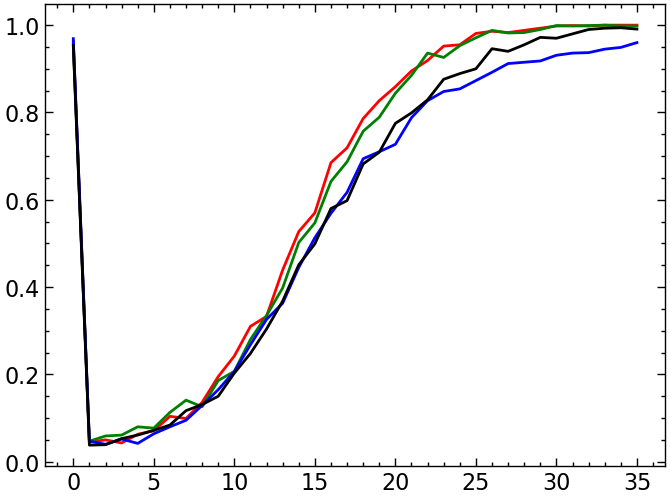

In [76]:
plt.plot(snr_range, accuracy_s0l_r1_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r1_C, color = "green")
plt.plot(snr_range, accuracy_s1_r1_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r1_C, color = "black")

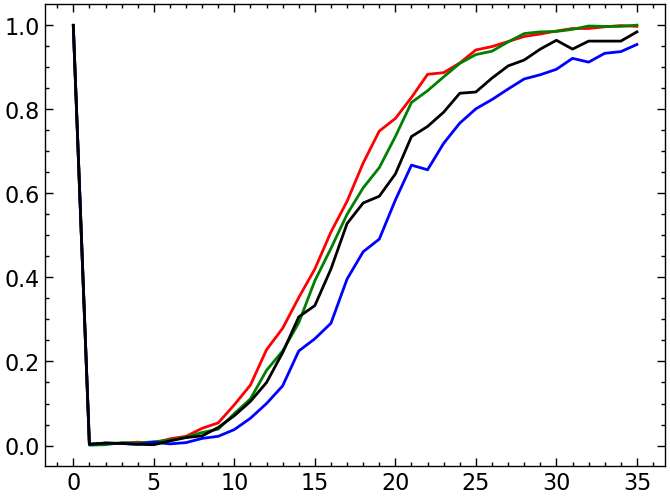

In [53]:
plt.plot(snr_range, accuracy_s0l_r1_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r1_C, color = "green")
plt.plot(snr_range, accuracy_s1_r1_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r1_C, color = "black")

In [236]:
with open('store/files/binary_classifier_all_spins/accuracy_vs_S_allspins_r1_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r1_C': accuracy_s0l_r1_C,
        'accuracy_s0q_r1_C': accuracy_s0q_r1_C,
        'accuracy_s1_r1_C': accuracy_s1_r1_C,
        'accuracy_s2_r1_C': accuracy_s2_r1_C
    }, f)

#### Accuracy: 2. run

In [81]:
loss_s0l_r2_C     = []
accuracy_s0l_r2_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r2_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r2_C.append(loss)
    accuracy_s0l_r2_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9953 - loss: 0.0252
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0072 - loss: 6.5190
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0138 - loss: 6.1351
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0160 - loss: 6.1534
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0212 - loss: 5.9944
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0356 - loss: 5.5606
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0423 - loss: 5.2465
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0845 - loss: 4.7567
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0958 - loss: 4.4675
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1304 - loss: 4.0054
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2044 - loss: 3.4967
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2909 - loss: 2.7618
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3742 - loss: 2.3892
13
32/32 

In [82]:
loss_s0q_r2_C     = []
accuracy_s0q_r2_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r2_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r2_C.append(loss)
    accuracy_s0q_r2_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9911 - loss: 0.0309
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0185 - loss: 6.1482
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0135 - loss: 6.4700
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0145 - loss: 6.3559
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0149 - loss: 6.0491
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0273 - loss: 5.8981
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0328 - loss: 5.6705
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0601 - loss: 4.9837
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0879 - loss: 4.6988
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1511 - loss: 4.1446
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1793 - loss: 3.6683
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2720 - loss: 2.9853
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3184 - loss: 2.7693
13
32/32 

In [83]:
loss_s1_r2_C     = []
accuracy_s1_r2_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r2_C.evaluate(res_example_normalized, y_example)

    loss_s1_r2_C.append(loss)
    accuracy_s1_r2_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9924 - loss: 0.0345
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0133 - loss: 6.4611
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0233 - loss: 6.2828
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0096 - loss: 6.1908
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0106 - loss: 6.2246
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0212 - loss: 5.9347
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0215 - loss: 5.5742
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0652 - loss: 5.1118
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0567 - loss: 5.1153
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1125 - loss: 4.5498
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1918 - loss: 3.8154
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2105 - loss: 3.5374
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2649 - loss: 3.1671
13
32/32 

In [84]:
loss_s2_r2_C     = []
accuracy_s2_r2_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r2_C.evaluate(res_example_normalized, y_example)

    loss_s2_r2_C.append(loss)
    accuracy_s2_r2_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9865 - loss: 0.0356
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0146 - loss: 6.3946
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0172 - loss: 6.4242
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0198 - loss: 6.2438
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0106 - loss: 5.9359
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0192 - loss: 5.8869
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0298 - loss: 5.5884
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0613 - loss: 5.0285
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0729 - loss: 4.6014
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1240 - loss: 4.3272
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1787 - loss: 3.8527
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2037 - loss: 3.4779
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2853 - loss: 2.8502
13
32/32 

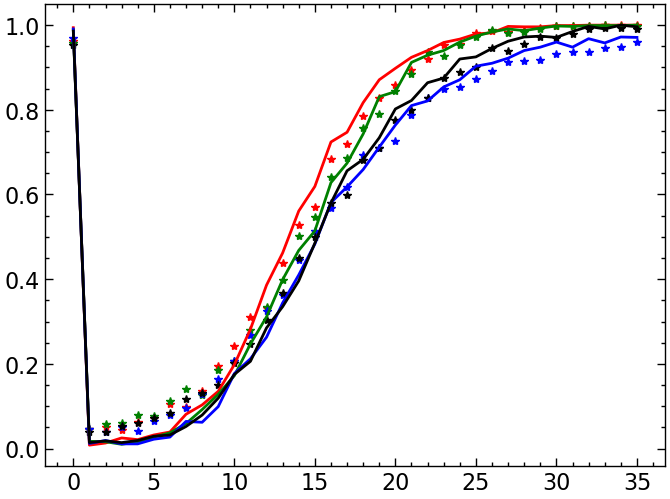

In [85]:
plt.plot(snr_range, accuracy_s0l_r1_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r1_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r1_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r1_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r2_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r2_C, color = "green")
plt.plot(snr_range, accuracy_s1_r2_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r2_C, color = "black")

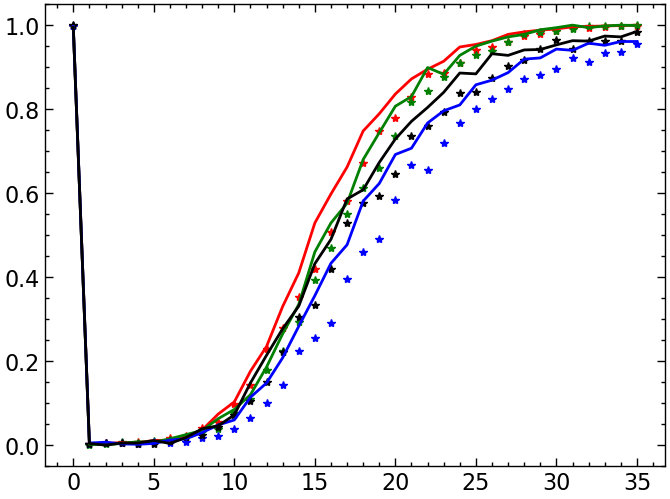

In [58]:
plt.plot(snr_range, accuracy_s0l_r1_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r1_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r1_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r1_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r2_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r2_C, color = "green")
plt.plot(snr_range, accuracy_s1_r2_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r2_C, color = "black")

In [238]:
with open('store/files/binary_classifier_all_spins/accuracy_vs_S_allspins_r2_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r2_C': accuracy_s0l_r2_C,
        'accuracy_s0q_r2_C': accuracy_s0q_r2_C,
        'accuracy_s1_r2_C': accuracy_s1_r2_C,
        'accuracy_s2_r2_C': accuracy_s2_r2_C
    }, f)

#### Accuracy: 3. run

In [91]:
loss_s0l_r3_C     = []
accuracy_s0l_r3_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r3_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r3_C.append(loss)
    accuracy_s0l_r3_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9918 - loss: 0.0202
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0030 - loss: 7.2932
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0145 - loss: 6.9851
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0037 - loss: 6.8044
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0096 - loss: 6.7505
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0108 - loss: 6.5255
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0208 - loss: 6.1902
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0188 - loss: 5.7504
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0402 - loss: 5.4466
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0931 - loss: 4.6307
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1360 - loss: 4.2204
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1838 - loss: 3.7215
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2486 - loss: 3.2242
13
32/32 

In [92]:
loss_s0q_r3_C     = []
accuracy_s0q_r3_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r3_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r3_C.append(loss)
    accuracy_s0q_r3_C.append(accuracy)


0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9918 - loss: 0.0225
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0045 - loss: 7.0739
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0077 - loss: 7.2857
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0109 - loss: 6.8444
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0065 - loss: 6.7803
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0118 - loss: 6.7870
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0120 - loss: 6.4208
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0303 - loss: 5.9329
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0478 - loss: 5.3872
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0758 - loss: 4.9008
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1136 - loss: 4.5741
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1285 - loss: 4.1547
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2014 - loss: 3.7476
13
32/32 

In [93]:
loss_s1_r3_C     = []
accuracy_s1_r3_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r3_C.evaluate(res_example_normalized, y_example)

    loss_s1_r3_C.append(loss)
    accuracy_s1_r3_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9883 - loss: 0.0297
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0027 - loss: 7.3244 
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0049 - loss: 7.3085
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0061 - loss: 6.9125
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0059 - loss: 6.8118
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0179 - loss: 6.4691
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0191 - loss: 6.2786
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0280 - loss: 5.9855
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0239 - loss: 5.3842
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0817 - loss: 5.3456
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1048 - loss: 4.9114
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1651 - loss: 4.1551
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2239 - loss: 3.6139
13
32/32

In [94]:
loss_s2_r3_C     = []
accuracy_s2_r3_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r3_C.evaluate(res_example_normalized, y_example)

    loss_s2_r3_C.append(loss)
    accuracy_s2_r3_C.append(accuracy)


0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9939 - loss: 0.0208
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0079 - loss: 7.2038
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0140 - loss: 7.0304
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0042 - loss: 7.0378
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0093 - loss: 6.8672
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0115 - loss: 6.6646
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0152 - loss: 6.1584
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0225 - loss: 5.9341
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0387 - loss: 5.6037
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0696 - loss: 5.0517
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1052 - loss: 4.6099
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1569 - loss: 4.0475
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1844 - loss: 3.6140
13
32/32 

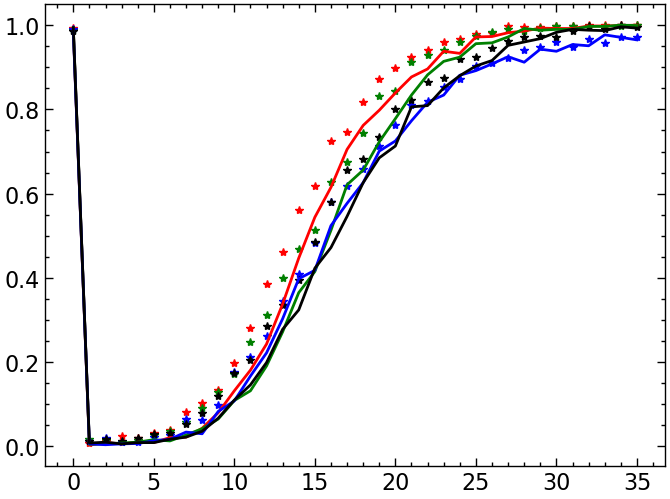

In [95]:
plt.plot(snr_range, accuracy_s0l_r2_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r2_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r2_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r2_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r3_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r3_C, color = "green")
plt.plot(snr_range, accuracy_s1_r3_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r3_C, color = "black")

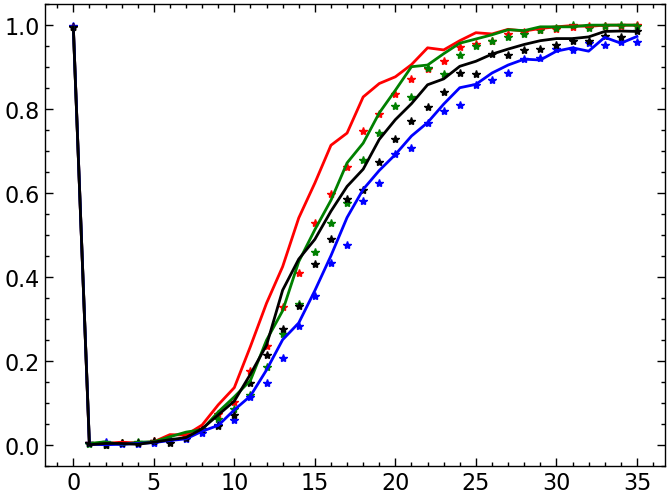

In [63]:
plt.plot(snr_range, accuracy_s0l_r2_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r2_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r2_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r2_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r3_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r3_C, color = "green")
plt.plot(snr_range, accuracy_s1_r3_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r3_C, color = "black")

In [240]:
with open('store/files/binary_classifier_all_spins/accuracy_vs_S_allspins_r3_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r3_C': accuracy_s0l_r3_C,
        'accuracy_s0q_r3_C': accuracy_s0q_r3_C,
        'accuracy_s1_r3_C': accuracy_s1_r3_C,
        'accuracy_s2_r3_C': accuracy_s2_r3_C
    }, f)

#### Accuracy: 4. run

In [99]:
loss_s0l_r4_C     = []
accuracy_s0l_r4_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r4_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r4_C.append(loss)
    accuracy_s0l_r4_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9955 - loss: 0.0155
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0038 - loss: 9.5655
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0086 - loss: 9.0297
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0094 - loss: 9.0870
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0047 - loss: 8.7264
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0153 - loss: 8.4921
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0335 - loss: 8.0018
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0309 - loss: 7.3354
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0852 - loss: 6.2630
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1241 - loss: 5.9131
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1832 - loss: 5.2082
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2612 - loss: 4.0807
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3557 - loss: 3.2780
13
32/32 

In [100]:
loss_s0q_r4_C     = []
accuracy_s0q_r4_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r4_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r4_C.append(loss)
    accuracy_s0q_r4_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9969 - loss: 0.0185
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0084 - loss: 9.4119
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0107 - loss: 9.0828
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0072 - loss: 9.1555
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0129 - loss: 8.9077
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0090 - loss: 8.3391
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0327 - loss: 7.8993
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0481 - loss: 7.5058
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0559 - loss: 6.9404
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1006 - loss: 6.2917
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1528 - loss: 5.4376
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2070 - loss: 4.8056
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2964 - loss: 3.9357
13
32/32 

In [101]:
loss_s1_r4_C     = []
accuracy_s1_r4_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r4_C.evaluate(res_example_normalized, y_example)

    loss_s1_r4_C.append(loss)
    accuracy_s1_r4_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9980 - loss: 0.0108
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0082 - loss: 9.4249
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0079 - loss: 9.2784
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 6.0767e-04 - loss: 9.3365
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0103 - loss: 8.8336
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0220 - loss: 8.4156
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0229 - loss: 8.2683
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0372 - loss: 7.8481
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0489 - loss: 7.6801
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0811 - loss: 6.6935
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1136 - loss: 6.1714
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1652 - loss: 5.6212
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2399 - loss: 4.6425
13
32

In [102]:
loss_s2_r4_C     = []
accuracy_s2_r4_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r4_C.evaluate(res_example_normalized, y_example)

    loss_s2_r4_C.append(loss)
    accuracy_s2_r4_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9976 - loss: 0.0097
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0038 - loss: 9.5927
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0088 - loss: 9.2557
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0083 - loss: 8.7698
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0099 - loss: 8.5941
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0238 - loss: 8.2827
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0216 - loss: 8.1692
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0338 - loss: 7.6281
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0544 - loss: 7.1997
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0842 - loss: 6.4750
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1229 - loss: 5.9697
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1963 - loss: 4.9118
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2945 - loss: 4.1895
13
32/32 

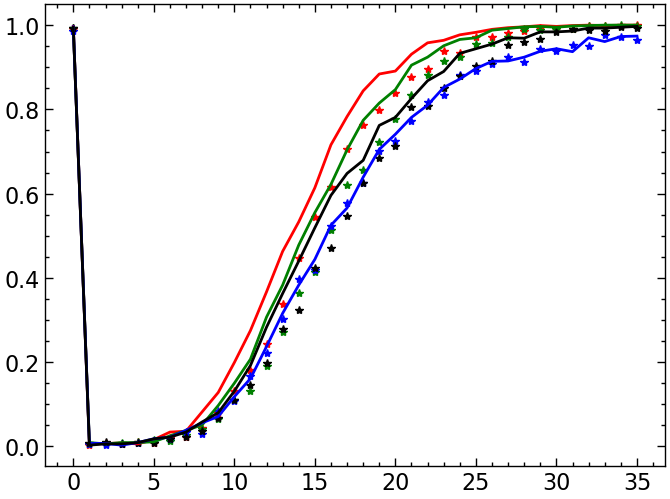

In [103]:
plt.plot(snr_range, accuracy_s0l_r3_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r3_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r3_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r3_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r4_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r4_C, color = "green")
plt.plot(snr_range, accuracy_s1_r4_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r4_C, color = "black")

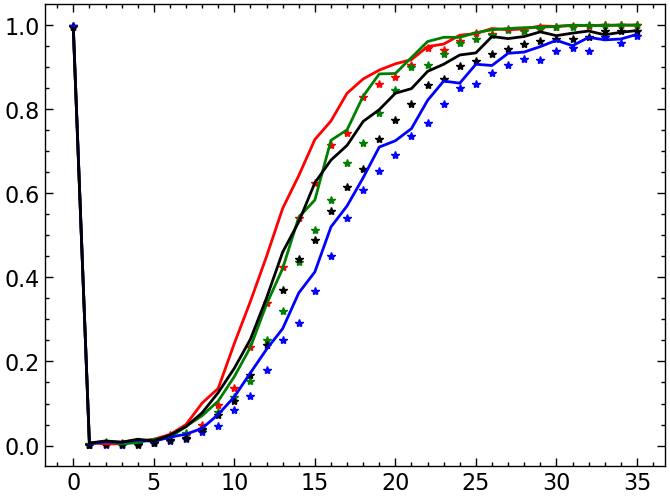

In [69]:
plt.plot(snr_range, accuracy_s0l_r3_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r3_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r3_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r3_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r4_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r4_C, color = "green")
plt.plot(snr_range, accuracy_s1_r4_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r4_C, color = "black")

In [242]:
with open('store/files/binary_classifier_all_spins/accuracy_vs_S_allspins_r4_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r4_C': accuracy_s0l_r4_C,
        'accuracy_s0q_r4_C': accuracy_s0q_r4_C,
        'accuracy_s1_r4_C': accuracy_s1_r4_C,
        'accuracy_s2_r4_C': accuracy_s2_r4_C
    }, f)

In [101]:
with open('store/files/binary_classifier_all_spins/accuracy_vs_S_s0l_r1_r4_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r1_C': accuracy_s0l_r1_C,
        'accuracy_s0l_r2_C': accuracy_s0l_r2_C,
        'accuracy_s0l_r3_C': accuracy_s0l_r3_C,
        'accuracy_s0l_r4_C': accuracy_s0l_r4_C
    }, f)

with open('store/files/binary_classifier_all_spins/accuracy_vs_S_s0q_r1_r4_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0q_r1_C': accuracy_s0q_r1_C,
        'accuracy_s0q_r2_C': accuracy_s0q_r2_C,
        'accuracy_s0q_r3_C': accuracy_s0q_r3_C,
        'accuracy_s0q_r4_C': accuracy_s0q_r4_C
    }, f)

with open('store/files/binary_classifier_all_spins/accuracy_vs_S_s1_r1_r4_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s1_r1_C': accuracy_s1_r1_C,
        'accuracy_s1_r2_C': accuracy_s1_r2_C,
        'accuracy_s1_r3_C': accuracy_s1_r3_C,
        'accuracy_s1_r4_C': accuracy_s1_r4_C
    }, f)

with open('store/files/binary_classifier_all_spins/accuracy_vs_S_s2_r1_r4_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s2_r1_C': accuracy_s2_r1_C,
        'accuracy_s2_r2_C': accuracy_s2_r2_C,
        'accuracy_s2_r3_C': accuracy_s2_r3_C,
        'accuracy_s2_r4_C': accuracy_s2_r4_C
    }, f)

#### Accuracy: 5. run

In [187]:
loss_s0l_r5_C     = []
accuracy_s0l_r5_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r5_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r5_C.append(loss)
    accuracy_s0l_r5_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9987 - loss: 0.0057
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0044 - loss: 11.3407
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0013 - loss: 11.2854  
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.5537e-04 - loss: 11.3815
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0080 - loss: 11.0024
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0095 - loss: 10.1814
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0179 - loss: 9.8266
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0248 - loss: 9.2298
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0456 - loss: 8.1683
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0827 - loss: 7.0366
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1491 - loss: 6.0283
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2324 - loss: 5.0142
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3371 - loss: 4.203

In [188]:
loss_s0q_r5_C     = []
accuracy_s0q_r5_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r5_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r5_C.append(loss)
    accuracy_s0q_r5_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9982 - loss: 0.0062
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0024 - loss: 11.5756
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0067 - loss: 11.0425
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0030 - loss: 11.2324
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0016 - loss: 10.9875
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0041 - loss: 10.5732
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0092 - loss: 9.9140
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0183 - loss: 9.6056
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0633 - loss: 8.4289
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0400 - loss: 8.0416
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1002 - loss: 7.1922
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1286 - loss: 6.3390
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2340 - loss: 5.2986
13
3

In [189]:
loss_s1_r5_C     = []
accuracy_s1_r5_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r5_C.evaluate(res_example_normalized, y_example)

    loss_s1_r5_C.append(loss)
    accuracy_s1_r5_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0023
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0052 - loss: 11.3918
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0010 - loss: 11.5394    
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0021 - loss: 11.2500
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0053 - loss: 11.0045
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0111 - loss: 10.7388
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0088 - loss: 10.0822
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0247 - loss: 9.7706
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0188 - loss: 9.1746
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0421 - loss: 8.7102
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0913 - loss: 7.6346
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1043 - loss: 7.2500
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1814 - loss: 6.4438

In [190]:
loss_s2_r5_C     = []
accuracy_s2_r5_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r5_C.evaluate(res_example_normalized, y_example)

    loss_s2_r5_C.append(loss)
    accuracy_s2_r5_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9998 - loss: 0.0030
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0015 - loss: 11.5041
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0010 - loss: 11.5337  
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0030 - loss: 11.1398
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0050 - loss: 10.9594
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0046 - loss: 10.4814
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0272 - loss: 10.0235
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0156 - loss: 9.4078
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0230 - loss: 8.8787
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0859 - loss: 7.8788
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1178 - loss: 7.2263
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1555 - loss: 6.6532
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2288 - loss: 5.5135
1

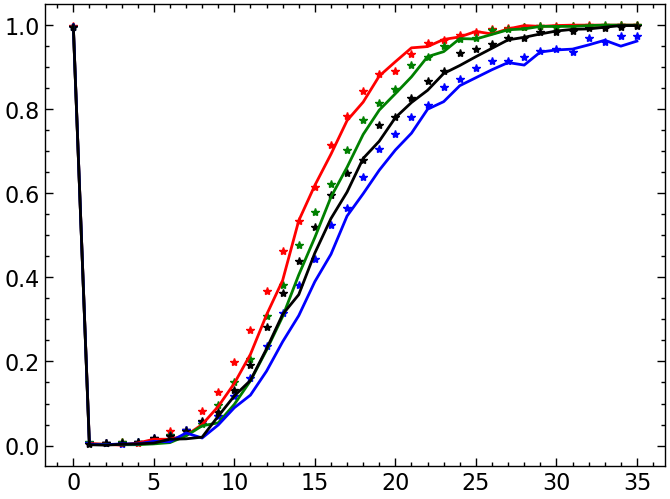

In [232]:
plt.plot(snr_range, accuracy_s0l_r4_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r4_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r4_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r4_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r5_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r5_C, color = "green")
plt.plot(snr_range, accuracy_s1_r5_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r5_C, color = "black")

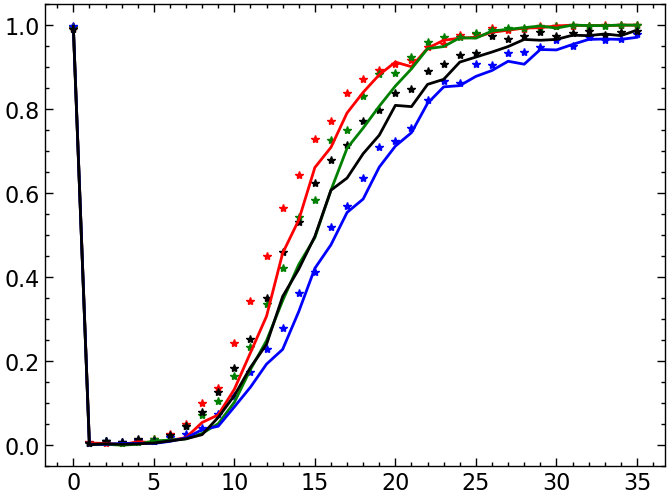

In [147]:
plt.plot(snr_range, accuracy_s0l_r4_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r4_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r4_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r4_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r5_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r5_C, color = "green")
plt.plot(snr_range, accuracy_s1_r5_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r5_C, color = "black")

In [234]:
with open('store/files/binary_classifier_all_spins/accuracy_vs_S_allspins_r5_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r5_C': accuracy_s0l_r5_C,
        'accuracy_s0q_r5_C': accuracy_s0q_r5_C,
        'accuracy_s1_r5_C': accuracy_s1_r5_C,
        'accuracy_s2_r5_C': accuracy_s2_r5_C
    }, f)

#### Accuracy: 6. run

In [255]:
loss_s0l_r6_C     = []
accuracy_s0l_r6_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r6_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r6_C.append(loss)
    accuracy_s0l_r6_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9832 - loss: 0.0805
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0168 - loss: 6.8673
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0134 - loss: 6.8377
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0273 - loss: 6.4230
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0293 - loss: 6.0157
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0436 - loss: 5.8719
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0773 - loss: 5.2509
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1220 - loss: 4.4771
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1949 - loss: 4.0314
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2828 - loss: 3.2569
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4217 - loss: 2.3519
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4967 - loss: 2.0086
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6481 - loss: 1.2643
13
32/32 

In [256]:
loss_s0q_r6_C     = []
accuracy_s0q_r6_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r6_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r6_C.append(loss)
    accuracy_s0q_r6_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9865 - loss: 0.0396
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0211 - loss: 6.9876
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0300 - loss: 6.5134
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0181 - loss: 6.5786
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0254 - loss: 6.2099
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0455 - loss: 6.0649
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0706 - loss: 5.2965
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1068 - loss: 5.0109
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1369 - loss: 4.3682
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2375 - loss: 3.7643
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3347 - loss: 2.9790
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3784 - loss: 2.7702
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5142 - loss: 1.9235
13
32/32 

In [257]:
loss_s1_r6_C     = []
accuracy_s1_r6_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r6_C.evaluate(res_example_normalized, y_example)

    loss_s1_r6_C.append(loss)
    accuracy_s1_r6_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9873 - loss: 0.0380
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0149 - loss: 6.8572
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0155 - loss: 6.5498
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0178 - loss: 6.6138
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0344 - loss: 6.4580
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0428 - loss: 6.0045
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0516 - loss: 5.8867
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0729 - loss: 5.6650
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0965 - loss: 5.2404
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1500 - loss: 4.7308
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2009 - loss: 4.0302
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2651 - loss: 3.7869
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3016 - loss: 3.4048
13
32/32 

In [258]:
loss_s2_r6_C     = []
accuracy_s2_r6_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r6_C.evaluate(res_example_normalized, y_example)

    loss_s2_r6_C.append(loss)
    accuracy_s2_r6_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9800 - loss: 0.0587
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0197 - loss: 6.7390
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0130 - loss: 7.0186
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0183 - loss: 6.6446
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0288 - loss: 6.1966
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0383 - loss: 6.1184
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0628 - loss: 5.4447
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0767 - loss: 5.0174
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1506 - loss: 4.4674
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2054 - loss: 3.9980
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2942 - loss: 3.3179
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3659 - loss: 2.7984
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4970 - loss: 2.1024
13
32/32 

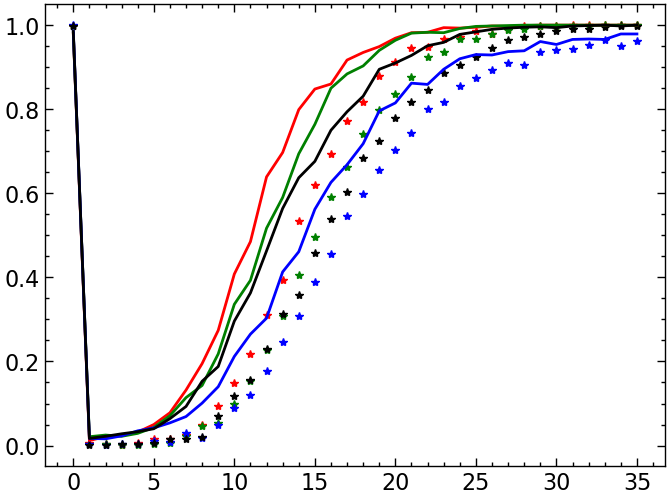

In [259]:
plt.plot(snr_range, accuracy_s0l_r5_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r5_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r5_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r5_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r6_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r6_C, color = "green")
plt.plot(snr_range, accuracy_s1_r6_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r6_C, color = "black")

In [260]:
with open('store/files/binary_classifier_all_spins/accuracy_vs_S_allspins_r6_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r6_C': accuracy_s0l_r6_C,
        'accuracy_s0q_r6_C': accuracy_s0q_r6_C,
        'accuracy_s1_r6_C': accuracy_s1_r6_C,
        'accuracy_s2_r6_C': accuracy_s2_r6_C
    }, f)

#### Accuracy: 7. run

In [269]:
loss_s0l_r7_C     = []
accuracy_s0l_r7_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r7_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r7_C.append(loss)
    accuracy_s0l_r7_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9882 - loss: 0.0495
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0104 - loss: 6.1598
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0132 - loss: 5.9567
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0217 - loss: 5.4634
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0342 - loss: 5.1752
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0444 - loss: 4.9936
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0796 - loss: 4.2096
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1453 - loss: 3.8711
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2183 - loss: 3.0955
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2897 - loss: 2.6244
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4597 - loss: 2.0494
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5308 - loss: 1.5547
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6957 - loss: 1.0445
13
32/32 

In [270]:
loss_s0q_r7_C     = []
accuracy_s0q_r7_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r7_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r7_C.append(loss)
    accuracy_s0q_r7_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9896 - loss: 0.0541
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0181 - loss: 5.8663
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0133 - loss: 5.9052
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0261 - loss: 5.6070
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0300 - loss: 5.3737
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0416 - loss: 4.8347
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0767 - loss: 4.7213
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1158 - loss: 4.0476
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1987 - loss: 3.4900
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2627 - loss: 3.1301
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3143 - loss: 2.5202
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4496 - loss: 2.0498
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5795 - loss: 1.4242
13
32/32 

In [271]:
loss_s1_r7_C     = []
accuracy_s1_r7_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r7_C.evaluate(res_example_normalized, y_example)

    loss_s1_r7_C.append(loss)
    accuracy_s1_r7_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9793 - loss: 0.0614
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0129 - loss: 5.8873
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0115 - loss: 6.0877
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0220 - loss: 5.8612
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0198 - loss: 5.5894
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0364 - loss: 5.2415
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0408 - loss: 5.1805
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0702 - loss: 4.9026
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1013 - loss: 4.3317
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1557 - loss: 4.0168
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2033 - loss: 3.4897
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2652 - loss: 3.1263
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3609 - loss: 2.5482
13
32/32 

In [272]:
loss_s2_r7_C     = []
accuracy_s2_r7_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r7_C.evaluate(res_example_normalized, y_example)

    loss_s2_r7_C.append(loss)
    accuracy_s2_r7_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9831 - loss: 0.0624
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0183 - loss: 6.0950
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0124 - loss: 6.0473
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0232 - loss: 5.5698
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0348 - loss: 5.4451
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0422 - loss: 4.9130
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0707 - loss: 4.8593
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0783 - loss: 4.1285
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1483 - loss: 3.8493
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2172 - loss: 3.3444
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2834 - loss: 2.7700
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3904 - loss: 2.2424
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4658 - loss: 2.0580
13
32/32 

In [273]:
with open('store/files/binary_classifier_all_spins/accuracy_vs_S_allspins_r7_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r7_C': accuracy_s0l_r7_C,
        'accuracy_s0q_r7_C': accuracy_s0q_r7_C,
        'accuracy_s1_r7_C': accuracy_s1_r7_C,
        'accuracy_s2_r7_C': accuracy_s2_r7_C
    }, f)

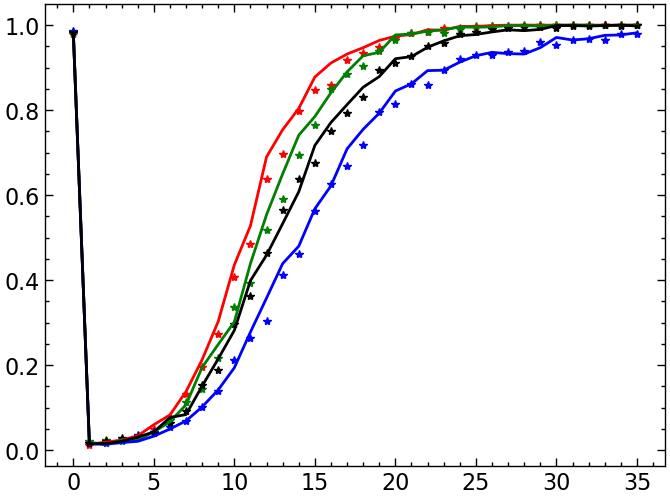

In [274]:
plt.plot(snr_range, accuracy_s0l_r6_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r6_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r6_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r6_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r7_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r7_C, color = "green")
plt.plot(snr_range, accuracy_s1_r7_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r7_C, color = "black")

#### Accuracy: 8. run

In [306]:
loss_s0l_r8_C     = []
accuracy_s0l_r8_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r8_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r8_C.append(loss)
    accuracy_s0l_r8_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9926 - loss: 0.0299
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0109 - loss: 8.1384
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0233 - loss: 8.1036
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0205 - loss: 7.3018
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0198 - loss: 7.1007
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0397 - loss: 6.8356
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0745 - loss: 6.2014
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1458 - loss: 4.8520
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2263 - loss: 4.1954
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3672 - loss: 3.3905
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4493 - loss: 2.5072
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5765 - loss: 1.7664
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6998 - loss: 1.3047
13
32/32 

In [307]:
loss_s0q_r8_C     = []
accuracy_s0q_r8_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r8_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r8_C.append(loss)
    accuracy_s0q_r8_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9869 - loss: 0.0325
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0102 - loss: 8.0826
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0141 - loss: 7.8709
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0311 - loss: 7.7577
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0234 - loss: 7.3004
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0329 - loss: 6.8924
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0881 - loss: 5.8217
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1119 - loss: 5.5656
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1740 - loss: 4.9941
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2631 - loss: 3.8811
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3855 - loss: 3.0675
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4727 - loss: 2.4666
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5950 - loss: 1.9542
13
32/32 

In [308]:
loss_s1_r8_C     = []
accuracy_s1_r8_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r8_C.evaluate(res_example_normalized, y_example)

    loss_s1_r8_C.append(loss)
    accuracy_s1_r8_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9855 - loss: 0.0607
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0115 - loss: 8.3227
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0157 - loss: 8.0243
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0092 - loss: 7.8825
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0185 - loss: 7.6716
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0294 - loss: 7.3911
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0427 - loss: 7.1424
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0562 - loss: 6.5069
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1029 - loss: 6.0618
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1451 - loss: 5.5265
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1904 - loss: 4.9615
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2989 - loss: 4.0696
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3442 - loss: 3.6053
13
32/32 

In [309]:
loss_s2_r8_C     = []
accuracy_s2_r8_C = []

# masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r8_C.evaluate(res_example_normalized, y_example)

    loss_s2_r8_C.append(loss)
    accuracy_s2_r8_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9794 - loss: 0.0560
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0140 - loss: 8.1764
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0124 - loss: 7.9933
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0212 - loss: 7.7981
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0188 - loss: 7.4002
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0462 - loss: 6.6946
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0461 - loss: 6.6998
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0853 - loss: 5.8976
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1399 - loss: 5.2987
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2089 - loss: 4.5350
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3304 - loss: 3.6490
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4135 - loss: 3.1300
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4919 - loss: 2.6939
13
32/32 

In [310]:
with open('store/files/binary_classifier_all_spins/accuracy_vs_S_allspins_r8_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r8_C': accuracy_s0l_r8_C,
        'accuracy_s0q_r8_C': accuracy_s0q_r8_C,
        'accuracy_s1_r8_C': accuracy_s1_r8_C,
        'accuracy_s2_r8_C': accuracy_s2_r8_C
    }, f)

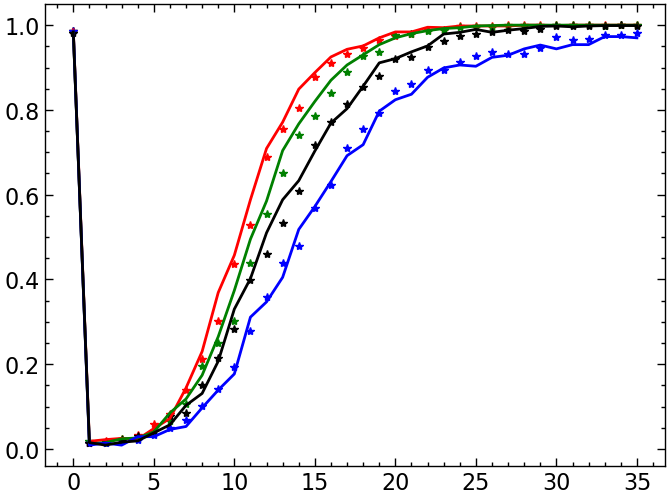

In [311]:
plt.plot(snr_range, accuracy_s0l_r7_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r7_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r7_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r7_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r8_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r8_C, color = "green")
plt.plot(snr_range, accuracy_s1_r8_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r8_C, color = "black")

#### Accuracy: 9. run

In [330]:
loss_s0l_r9_C     = []
accuracy_s0l_r9_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r9_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r9_C.append(loss)
    accuracy_s0l_r9_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9767 - loss: 0.1119
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0358 - loss: 4.2402
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0375 - loss: 4.2498
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0543 - loss: 3.8188
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0761 - loss: 3.6731
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1421 - loss: 3.0931
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1468 - loss: 2.7727
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2884 - loss: 2.2190
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3557 - loss: 1.8594
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5291 - loss: 1.2997
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5867 - loss: 0.9534
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7080 - loss: 0.6147
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8452 - loss: 0.3634
13
32/32 

In [331]:
loss_s0q_r9_C     = []
accuracy_s0q_r9_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r9_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r9_C.append(loss)
    accuracy_s0q_r9_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9698 - loss: 0.1083
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0359 - loss: 4.3193
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0343 - loss: 4.0367
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0338 - loss: 4.1493
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0630 - loss: 3.7228
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0869 - loss: 3.2985
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1208 - loss: 3.1889
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1938 - loss: 2.7654
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3034 - loss: 2.1591
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3803 - loss: 1.7168
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5035 - loss: 1.4018
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6273 - loss: 0.9431
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7039 - loss: 0.6688
13
32/32 

In [332]:
loss_s1_r9_C     = []
accuracy_s1_r9_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r9_C.evaluate(res_example_normalized, y_example)

    loss_s1_r9_C.append(loss)
    accuracy_s1_r9_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9729 - loss: 0.1153
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0338 - loss: 4.1776
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0343 - loss: 4.1999
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0413 - loss: 4.1181
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0527 - loss: 4.0230
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0759 - loss: 3.6200
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1007 - loss: 3.3520
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1277 - loss: 3.1902
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1721 - loss: 2.9328
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2566 - loss: 2.5986
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3164 - loss: 2.2660
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4194 - loss: 1.8894
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5436 - loss: 1.4154
13
32/32 

In [333]:
loss_s2_r9_C     = []
accuracy_s2_r9_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r9_C.evaluate(res_example_normalized, y_example)

    loss_s2_r9_C.append(loss)
    accuracy_s2_r9_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9673 - loss: 0.1248
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0329 - loss: 4.2392
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0333 - loss: 4.0340
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0597 - loss: 3.9785
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0647 - loss: 3.8009
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0913 - loss: 3.5421
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1127 - loss: 3.1884
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1628 - loss: 2.8898
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2576 - loss: 2.3027
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3292 - loss: 2.1480
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4213 - loss: 1.7908
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5422 - loss: 1.2770
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6253 - loss: 1.0196
13
32/32 

In [334]:
with open('store/files/binary_classifier_all_spins/accuracy_vs_S_allspins_r9_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r9_C': accuracy_s0l_r9_C,
        'accuracy_s0q_r9_C': accuracy_s0q_r9_C,
        'accuracy_s1_r9_C': accuracy_s1_r9_C,
        'accuracy_s2_r9_C': accuracy_s2_r9_C
    }, f)

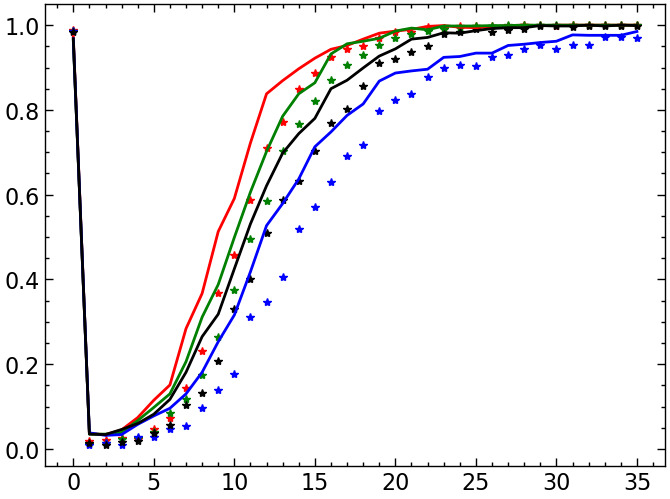

In [335]:
plt.plot(snr_range, accuracy_s0l_r8_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r8_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r8_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r8_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r9_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r9_C, color = "green")
plt.plot(snr_range, accuracy_s1_r9_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r9_C, color = "black")

#### Accuracy: 10. run

In [122]:
import pickle

# Load the scalar
with open('store/files/binary_classifier_all_spins/scaler_allsp_C.pkl', 'rb') as f:
    scaler_allsp_C = pickle.load(f)

best_model_r10_C = load_model("store/files/binary_classifier_all_spins/best_model_r10c_C.keras")

In [128]:
loss_s0l_r10_C     = []
accuracy_s0l_r10_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0l", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r10_C.evaluate(res_example_normalized, y_example)

    loss_s0l_r10_C.append(loss)
    accuracy_s0l_r10_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9295 - loss: 0.2376
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0505 - loss: 3.1758
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0702 - loss: 3.0872
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0921 - loss: 2.7369
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1465 - loss: 2.4096
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1826 - loss: 2.1584
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2871 - loss: 1.7219
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4402 - loss: 1.3473
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5282 - loss: 1.0360
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6870 - loss: 0.6476
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7708 - loss: 0.4765
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8613 - loss: 0.2959
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9061 - loss: 0.1708
13
32/32 

In [136]:
loss_s0q_r10_C     = []
accuracy_s0q_r10_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s0q", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r10_C.evaluate(res_example_normalized, y_example)

    loss_s0q_r10_C.append(loss)
    accuracy_s0q_r10_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9233 - loss: 0.2567
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0576 - loss: 3.0364
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0675 - loss: 3.0225
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0825 - loss: 2.8672
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1201 - loss: 2.6188
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1999 - loss: 2.3563
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2646 - loss: 2.0211
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3147 - loss: 1.7295
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4316 - loss: 1.3302
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5163 - loss: 1.0988
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6645 - loss: 0.7230
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7691 - loss: 0.5031
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8029 - loss: 0.3808
13
32/32 

In [137]:
loss_s1_r10_C     = []
accuracy_s1_r10_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s1", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r10_C.evaluate(res_example_normalized, y_example)

    loss_s1_r10_C.append(loss)
    accuracy_s1_r10_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9479 - loss: 0.1915
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0585 - loss: 3.2025
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0531 - loss: 3.0216
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0643 - loss: 3.0249
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0807 - loss: 3.0195
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0983 - loss: 2.8414
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1301 - loss: 2.5976
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1821 - loss: 2.2599
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2201 - loss: 2.1446
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2914 - loss: 1.8365
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3669 - loss: 1.6789
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4586 - loss: 1.4019
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5083 - loss: 1.0921
13
32/32 

In [138]:
loss_s2_r10_C     = []
accuracy_s2_r10_C = []

# Masses are randomly selected from the interval mmin to mmax
for j in snr_range:
    
    print(j)
    
    res_example            = Nruns_noisydata_SNR_fixed(N = 1000, m_list = [mmin, mmax], snr = j, spin = "s2", noise_model = "combined", nuis_control = 1)
    res_example_normalized = scaler_allsp_C.transform(res_example)

    if j == 0:
        y_example = np.zeros(len(res_example)).reshape(-1,1)
    else:
        y_example = np.ones(len(res_example)).reshape(-1,1)

    loss, accuracy = best_model_r10_C.evaluate(res_example_normalized, y_example)

    loss_s2_r10_C.append(loss)
    accuracy_s2_r10_C.append(accuracy)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9460 - loss: 0.2001
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0534 - loss: 3.2078
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0702 - loss: 3.0791
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0876 - loss: 2.8848
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0948 - loss: 2.5788
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1362 - loss: 2.5055
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2189 - loss: 2.1558
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2818 - loss: 1.8857
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3897 - loss: 1.6138
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4718 - loss: 1.2689
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5144 - loss: 1.1868
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6306 - loss: 0.8648
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7072 - loss: 0.6604
13
32/32 

In [146]:
with open('store/files/binary_classifier_all_spins/accuracy_vs_S_allspins_r10c2_C.pkl', 'wb') as f:
    pickle.dump({
        'accuracy_s0l_r10_C': accuracy_s0l_r10_C,
        'accuracy_s0q_r10_C': accuracy_s0q_r10_C,
        'accuracy_s1_r10_C': accuracy_s1_r10_C,
        'accuracy_s2_r10_C': accuracy_s2_r10_C
    }, f)

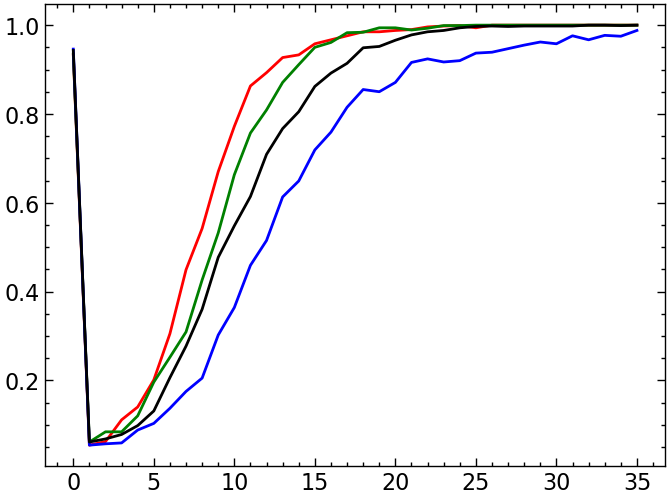

In [144]:
plt.plot(snr_range, accuracy_s0l_r10_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r10_C, color = "green")
plt.plot(snr_range, accuracy_s1_r10_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r10_C, color = "black")

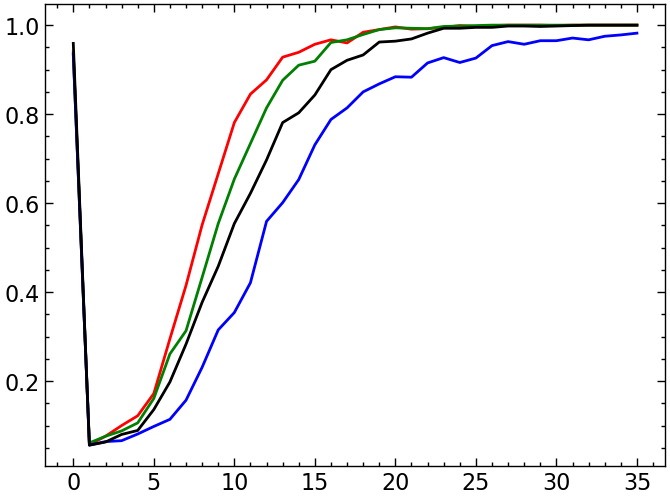

In [90]:
plt.plot(snr_range, accuracy_s0l_r10_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r10_C, color = "green")
plt.plot(snr_range, accuracy_s1_r10_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r10_C, color = "black")

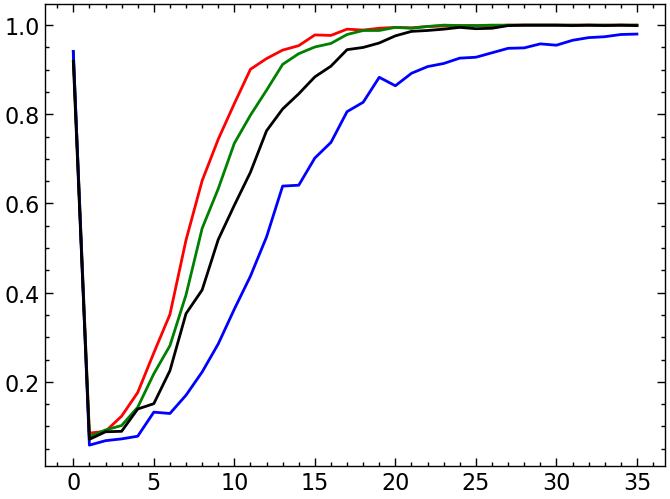

In [53]:
plt.plot(snr_range, accuracy_s0l_r10_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r10_C, color = "green")
plt.plot(snr_range, accuracy_s1_r10_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r10_C, color = "black")

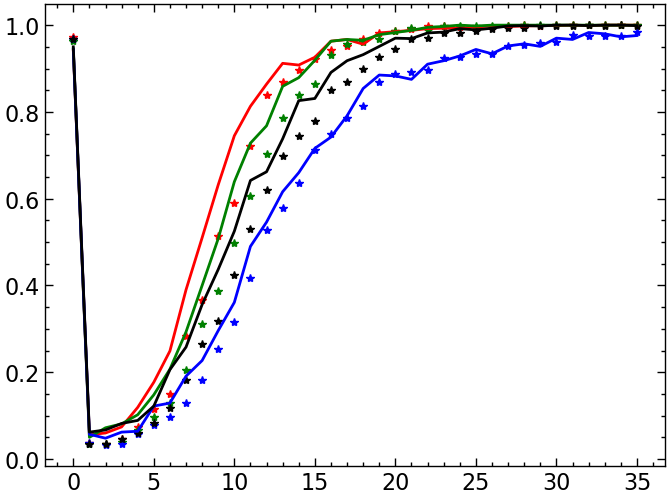

In [362]:
plt.plot(snr_range, accuracy_s0l_r9_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r9_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r9_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r9_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r10_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r10_C, color = "green")
plt.plot(snr_range, accuracy_s1_r10_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r10_C, color = "black")

#### Graphs

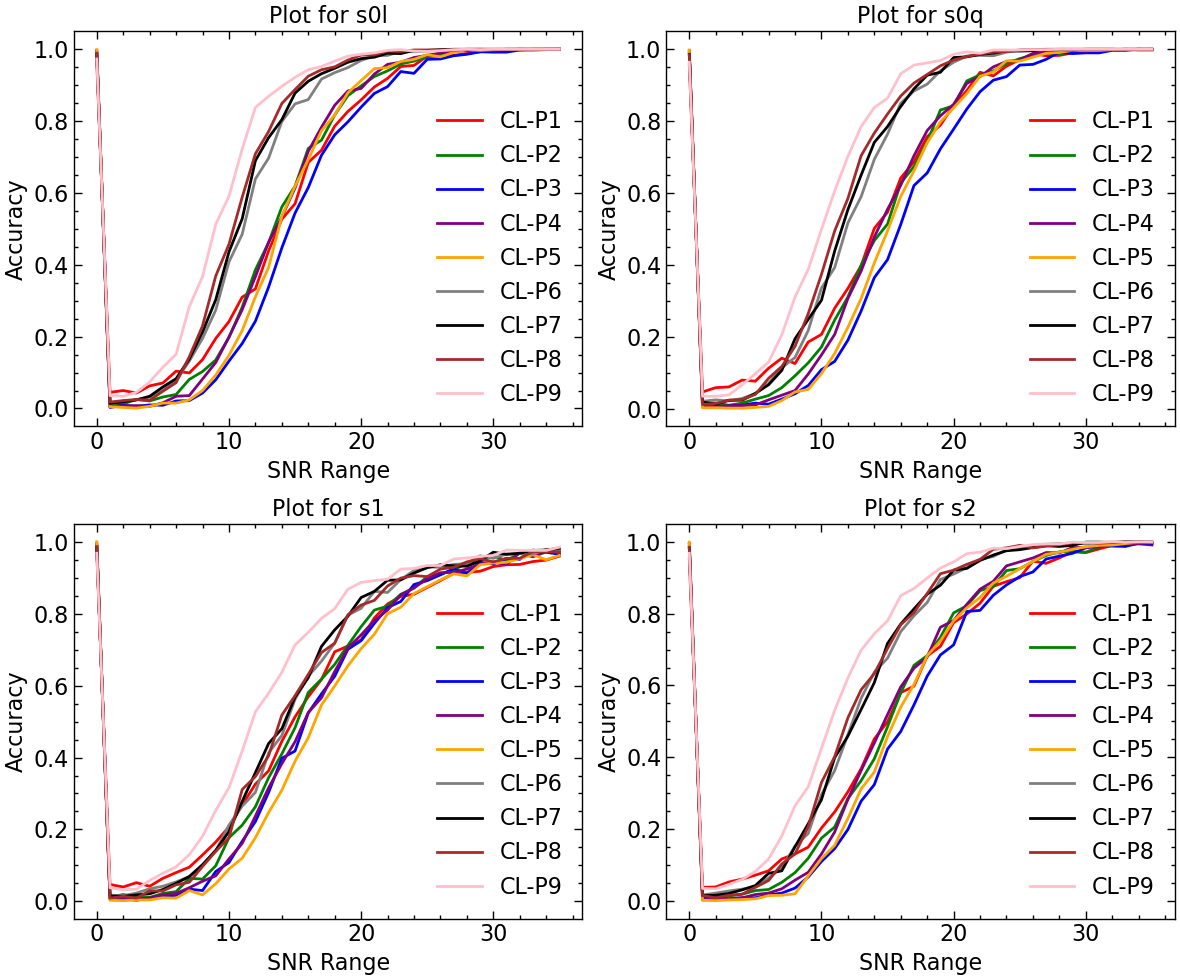

In [364]:
# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot for the first subplot
axs[0, 0].plot(snr_range, accuracy_s0l_r1_C, "-", color="red", label="CL-P1")
axs[0, 0].plot(snr_range, accuracy_s0l_r2_C, "-", color="green", label="CL-P2")
axs[0, 0].plot(snr_range, accuracy_s0l_r3_C, "-", color="blue", label="CL-P3")
axs[0, 0].plot(snr_range, accuracy_s0l_r4_C, "-", color="purple", label="CL-P4")
axs[0, 0].plot(snr_range, accuracy_s0l_r5_C, "-", color="orange", label="CL-P5")
axs[0, 0].plot(snr_range, accuracy_s0l_r6_C, "-", color="grey", label="CL-P6")
axs[0, 0].plot(snr_range, accuracy_s0l_r7_C, "-", color="black", label="CL-P7")
axs[0, 0].plot(snr_range, accuracy_s0l_r8_C, "-", color="brown", label="CL-P8")
axs[0, 0].plot(snr_range, accuracy_s0l_r9_C, "-", color="pink", label="CL-P9")
axs[0, 0].set_title("Plot for s0l")
axs[0, 0].set_xlabel("SNR Range")
axs[0, 0].set_ylabel("Accuracy")
axs[0, 0].legend()

# Plot for the second subplot (s0q)
axs[0, 1].plot(snr_range, accuracy_s0q_r1_C, "-", color="red", label="CL-P1")
axs[0, 1].plot(snr_range, accuracy_s0q_r2_C, "-", color="green", label="CL-P2")
axs[0, 1].plot(snr_range, accuracy_s0q_r3_C, "-", color="blue", label="CL-P3")
axs[0, 1].plot(snr_range, accuracy_s0q_r4_C, "-", color="purple", label="CL-P4")
axs[0, 1].plot(snr_range, accuracy_s0q_r5_C, "-", color="orange", label="CL-P5")
axs[0, 1].plot(snr_range, accuracy_s0q_r6_C, "-", color="grey", label="CL-P6")
axs[0, 1].plot(snr_range, accuracy_s0q_r7_C, "-", color="black", label="CL-P7")
axs[0, 1].plot(snr_range, accuracy_s0q_r8_C, "-", color="brown", label="CL-P8")
axs[0, 1].plot(snr_range, accuracy_s0q_r9_C, "-", color="pink", label="CL-P9")
axs[0, 1].set_title("Plot for s0q")
axs[0, 1].set_xlabel("SNR Range")
axs[0, 1].set_ylabel("Accuracy")
axs[0, 1].legend()

# Plot for the third subplot (s1)
axs[1, 0].plot(snr_range, accuracy_s1_r1_C, "-", color="red", label="CL-P1")
axs[1, 0].plot(snr_range, accuracy_s1_r2_C, "-", color="green", label="CL-P2")
axs[1, 0].plot(snr_range, accuracy_s1_r3_C, "-", color="blue", label="CL-P3")
axs[1, 0].plot(snr_range, accuracy_s1_r4_C, "-", color="purple", label="CL-P4")
axs[1, 0].plot(snr_range, accuracy_s1_r5_C, "-", color="orange", label="CL-P5")
axs[1, 0].plot(snr_range, accuracy_s1_r6_C, "-", color="grey", label="CL-P6")
axs[1, 0].plot(snr_range, accuracy_s1_r7_C, "-", color="black", label="CL-P7")
axs[1, 0].plot(snr_range, accuracy_s1_r8_C, "-", color="brown", label="CL-P8")
axs[1, 0].plot(snr_range, accuracy_s1_r9_C, "-", color="pink", label="CL-P9")
axs[1, 0].set_title("Plot for s1")
axs[1, 0].set_xlabel("SNR Range")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].legend()

# Plot for the fourth subplot (s2)
axs[1, 1].plot(snr_range, accuracy_s2_r1_C, "-", color="red", label="CL-P1")
axs[1, 1].plot(snr_range, accuracy_s2_r2_C, "-", color="green", label="CL-P2")
axs[1, 1].plot(snr_range, accuracy_s2_r3_C, "-", color="blue", label="CL-P3")
axs[1, 1].plot(snr_range, accuracy_s2_r4_C, "-", color="purple", label="CL-P4")
axs[1, 1].plot(snr_range, accuracy_s2_r5_C, "-", color="orange", label="CL-P5")
axs[1, 1].plot(snr_range, accuracy_s2_r6_C, "-", color="grey", label="CL-P6")
axs[1, 1].plot(snr_range, accuracy_s2_r7_C, "-", color="black", label="CL-P7")
axs[1, 1].plot(snr_range, accuracy_s2_r8_C, "-", color="brown", label="CL-P8")
axs[1, 1].plot(snr_range, accuracy_s2_r9_C, "-", color="pink", label="CL-P9")
axs[1, 1].set_title("Plot for s2")
axs[1, 1].set_xlabel("SNR Range")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

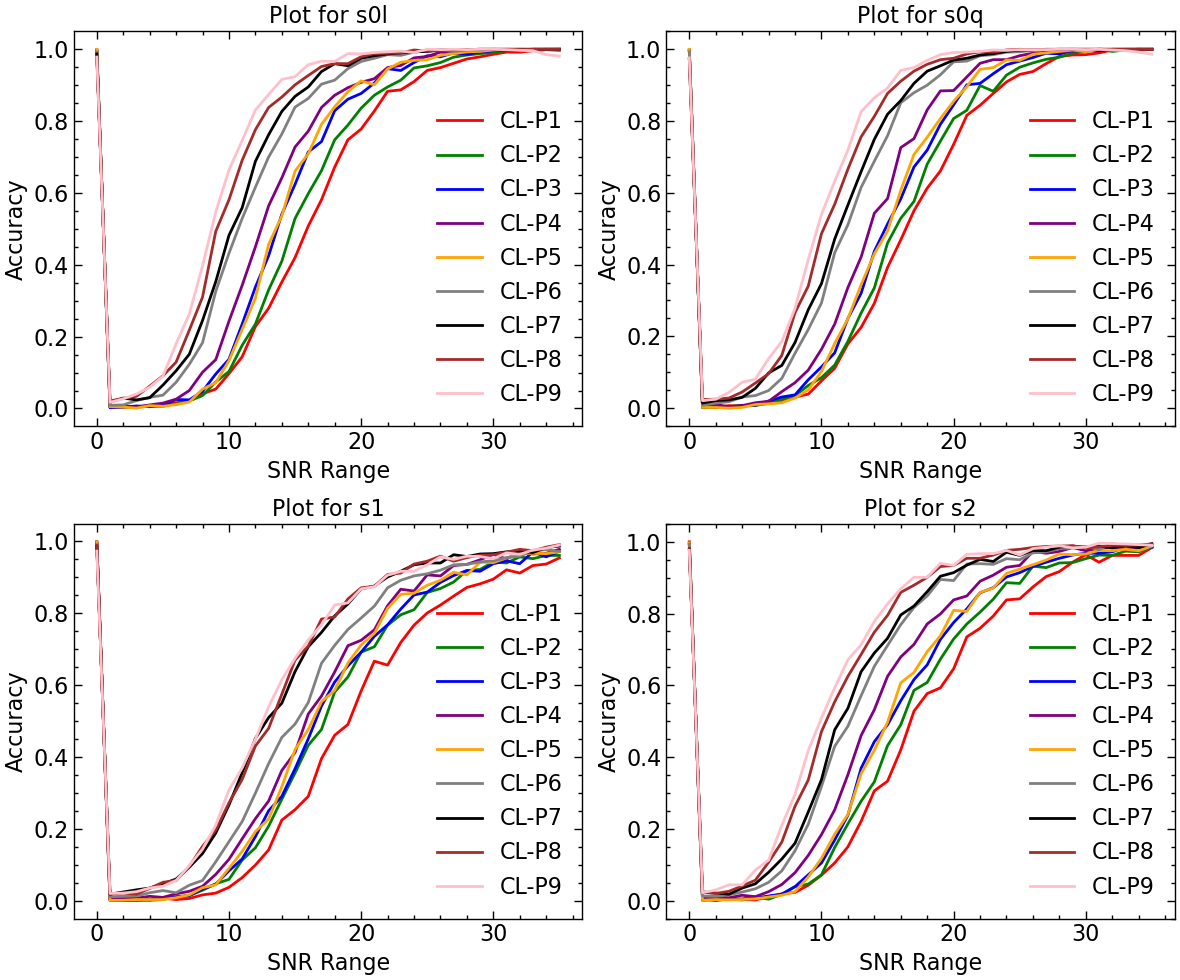

In [381]:
# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot for the first subplot
axs[0, 0].plot(snr_range, accuracy_s0l_r1_C, "-", color="red", label="CL-P1")
axs[0, 0].plot(snr_range, accuracy_s0l_r2_C, "-", color="green", label="CL-P2")
axs[0, 0].plot(snr_range, accuracy_s0l_r3_C, "-", color="blue", label="CL-P3")
axs[0, 0].plot(snr_range, accuracy_s0l_r4_C, "-", color="purple", label="CL-P4")
axs[0, 0].plot(snr_range, accuracy_s0l_r5_C, "-", color="orange", label="CL-P5")
axs[0, 0].plot(snr_range, accuracy_s0l_r6_C, "-", color="grey", label="CL-P6")
axs[0, 0].plot(snr_range, accuracy_s0l_r7_C, "-", color="black", label="CL-P7")
axs[0, 0].plot(snr_range, accuracy_s0l_r8_C, "-", color="brown", label="CL-P8")
axs[0, 0].plot(snr_range, accuracy_s0l_r9_C, "-", color="pink", label="CL-P9")
axs[0, 0].set_title("Plot for s0l")
axs[0, 0].set_xlabel("SNR Range")
axs[0, 0].set_ylabel("Accuracy")
axs[0, 0].legend()

# Plot for the second subplot (s0q)
axs[0, 1].plot(snr_range, accuracy_s0q_r1_C, "-", color="red", label="CL-P1")
axs[0, 1].plot(snr_range, accuracy_s0q_r2_C, "-", color="green", label="CL-P2")
axs[0, 1].plot(snr_range, accuracy_s0q_r3_C, "-", color="blue", label="CL-P3")
axs[0, 1].plot(snr_range, accuracy_s0q_r4_C, "-", color="purple", label="CL-P4")
axs[0, 1].plot(snr_range, accuracy_s0q_r5_C, "-", color="orange", label="CL-P5")
axs[0, 1].plot(snr_range, accuracy_s0q_r6_C, "-", color="grey", label="CL-P6")
axs[0, 1].plot(snr_range, accuracy_s0q_r7_C, "-", color="black", label="CL-P7")
axs[0, 1].plot(snr_range, accuracy_s0q_r8_C, "-", color="brown", label="CL-P8")
axs[0, 1].plot(snr_range, accuracy_s0q_r9_C, "-", color="pink", label="CL-P9")
axs[0, 1].set_title("Plot for s0q")
axs[0, 1].set_xlabel("SNR Range")
axs[0, 1].set_ylabel("Accuracy")
axs[0, 1].legend()

# Plot for the third subplot (s1)
axs[1, 0].plot(snr_range, accuracy_s1_r1_C, "-", color="red", label="CL-P1")
axs[1, 0].plot(snr_range, accuracy_s1_r2_C, "-", color="green", label="CL-P2")
axs[1, 0].plot(snr_range, accuracy_s1_r3_C, "-", color="blue", label="CL-P3")
axs[1, 0].plot(snr_range, accuracy_s1_r4_C, "-", color="purple", label="CL-P4")
axs[1, 0].plot(snr_range, accuracy_s1_r5_C, "-", color="orange", label="CL-P5")
axs[1, 0].plot(snr_range, accuracy_s1_r6_C, "-", color="grey", label="CL-P6")
axs[1, 0].plot(snr_range, accuracy_s1_r7_C, "-", color="black", label="CL-P7")
axs[1, 0].plot(snr_range, accuracy_s1_r8_C, "-", color="brown", label="CL-P8")
axs[1, 0].plot(snr_range, accuracy_s1_r9_C, "-", color="pink", label="CL-P9")
axs[1, 0].set_title("Plot for s1")
axs[1, 0].set_xlabel("SNR Range")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].legend()

# Plot for the fourth subplot (s2)
axs[1, 1].plot(snr_range, accuracy_s2_r1_C, "-", color="red", label="CL-P1")
axs[1, 1].plot(snr_range, accuracy_s2_r2_C, "-", color="green", label="CL-P2")
axs[1, 1].plot(snr_range, accuracy_s2_r3_C, "-", color="blue", label="CL-P3")
axs[1, 1].plot(snr_range, accuracy_s2_r4_C, "-", color="purple", label="CL-P4")
axs[1, 1].plot(snr_range, accuracy_s2_r5_C, "-", color="orange", label="CL-P5")
axs[1, 1].plot(snr_range, accuracy_s2_r6_C, "-", color="grey", label="CL-P6")
axs[1, 1].plot(snr_range, accuracy_s2_r7_C, "-", color="black", label="CL-P7")
axs[1, 1].plot(snr_range, accuracy_s2_r8_C, "-", color="brown", label="CL-P8")
axs[1, 1].plot(snr_range, accuracy_s2_r9_C, "-", color="pink", label="CL-P9")
axs[1, 1].set_title("Plot for s2")
axs[1, 1].set_xlabel("SNR Range")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

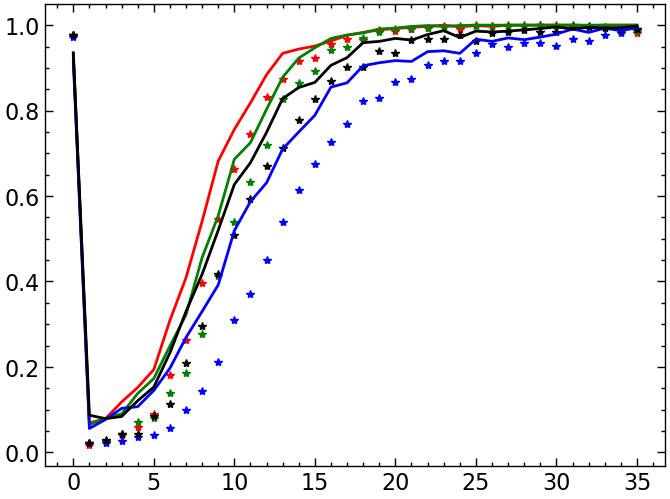

In [427]:
plt.plot(snr_range, accuracy_s0l_r9_C, "*", color = "red")
plt.plot(snr_range, accuracy_s0q_r9_C, "*", color = "green")
plt.plot(snr_range, accuracy_s1_r9_C, "*", color = "blue")
plt.plot(snr_range, accuracy_s2_r9_C, "*", color = "black")

plt.plot(snr_range, accuracy_s0l_r10_C, color = "red")
plt.plot(snr_range, accuracy_s0q_r10_C, color = "green")
plt.plot(snr_range, accuracy_s1_r10_C, color = "blue")
plt.plot(snr_range, accuracy_s2_r10_C, color = "black")